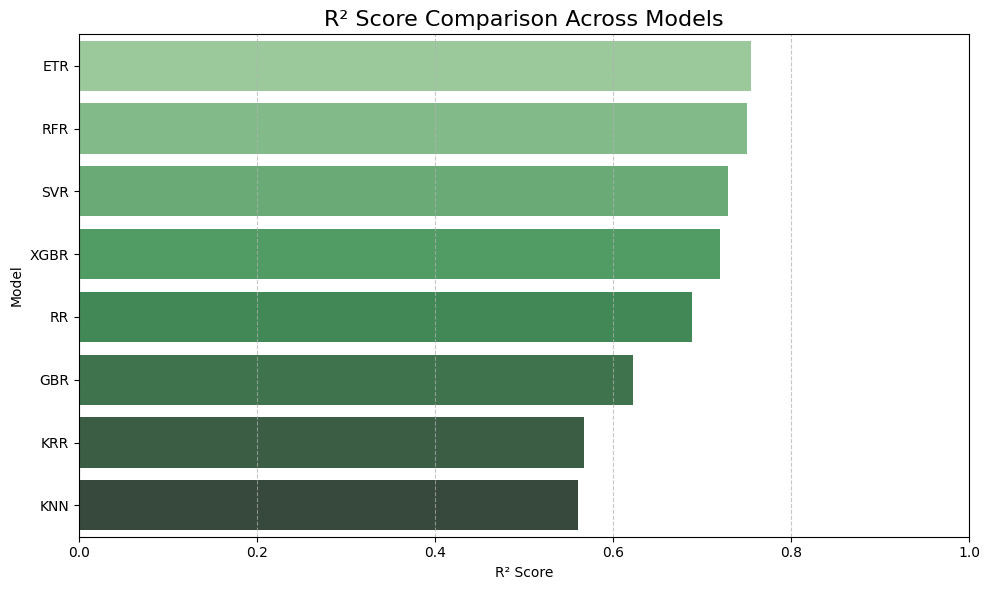

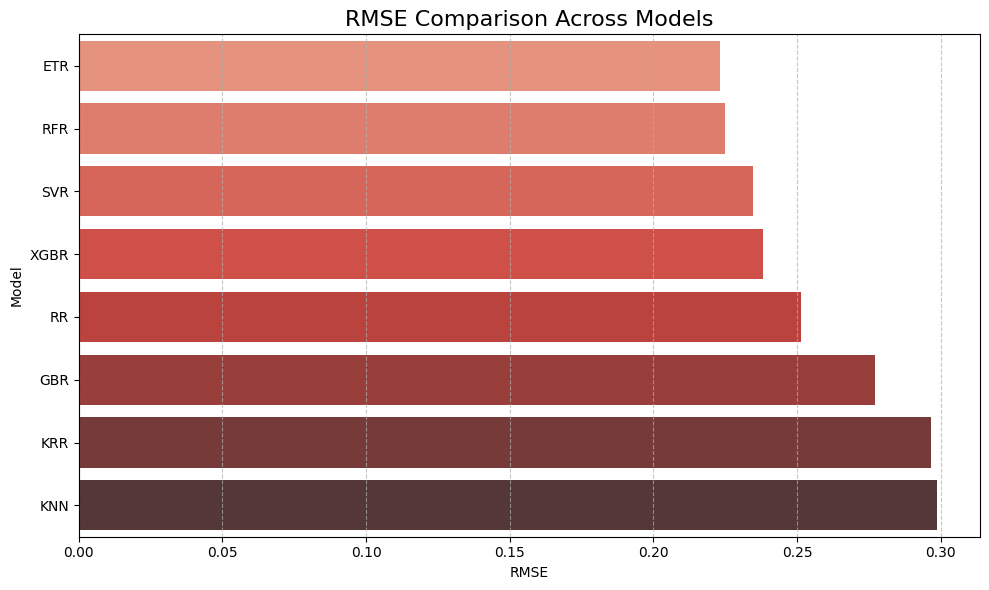

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Load data
data = pd.read_csv('data.txt', sep="\s+", index_col=0)
X = data.drop(columns=["$E_a$"])
y = data["$E_a$"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "RFR": RandomForestRegressor(n_estimators=100, random_state=42),
    "ETR": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(C=100, kernel='rbf'),
    "GBR": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RR": Ridge(alpha=1.0),
    "KRR": KernelRidge(alpha=1.0, kernel='rbf'),
    "XGBR": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Sort for plots
results_df_sorted_r2 = results_df.sort_values("R2", ascending=False)
results_df_sorted_rmse = results_df.sort_values("RMSE")

# Bar chart for R² scores
plt.figure(figsize=(10, 6))
sns.barplot(x="R2", y="Model", data=results_df_sorted_r2, palette="Greens_d")
plt.title("R² Score Comparison Across Models", fontsize=16)
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Bar chart for RMSE scores
plt.figure(figsize=(10, 6))
sns.barplot(x="RMSE", y="Model", data=results_df_sorted_rmse, palette="Reds_d")
plt.title("RMSE Comparison Across Models", fontsize=16)
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


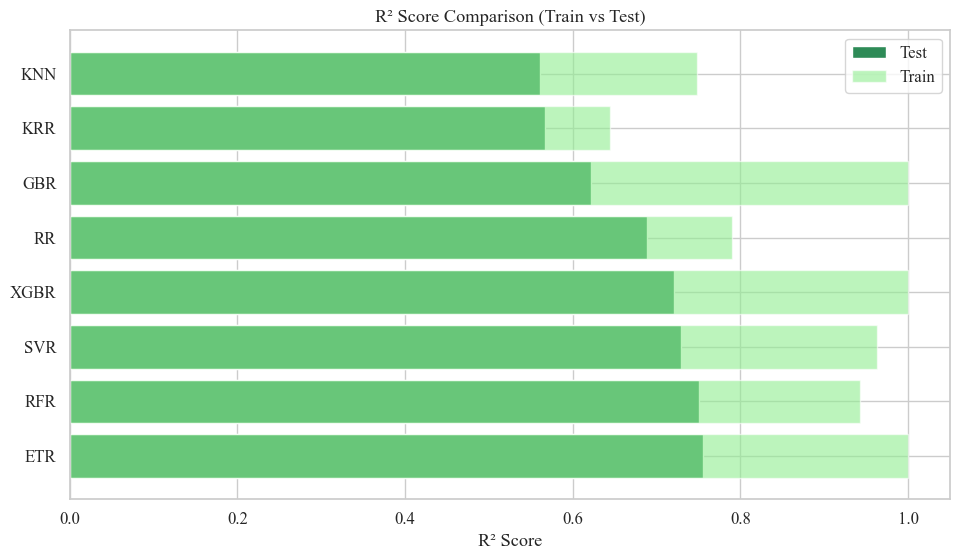

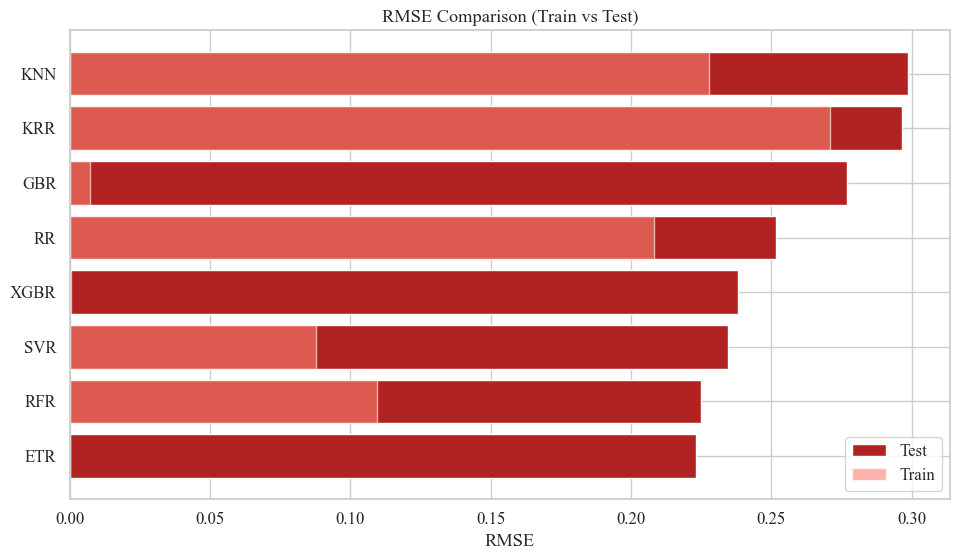

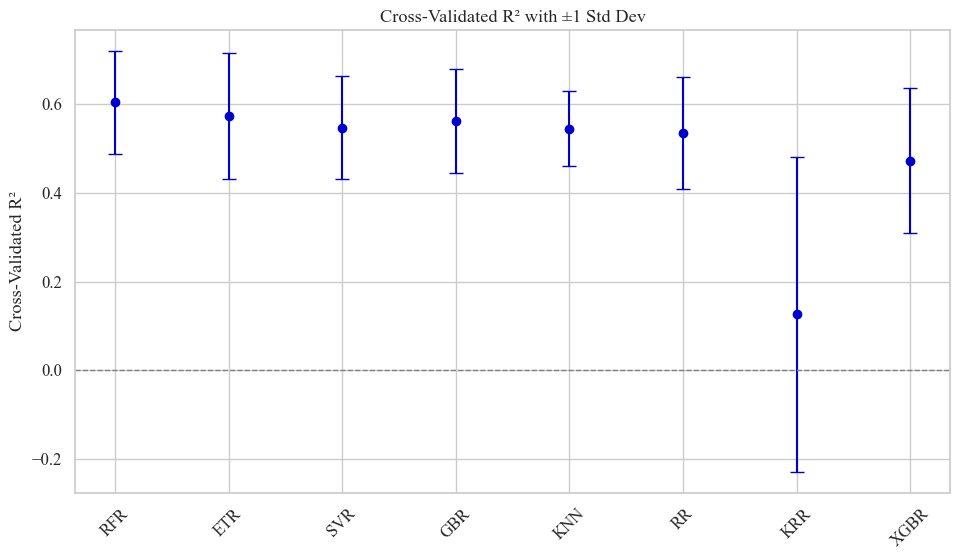

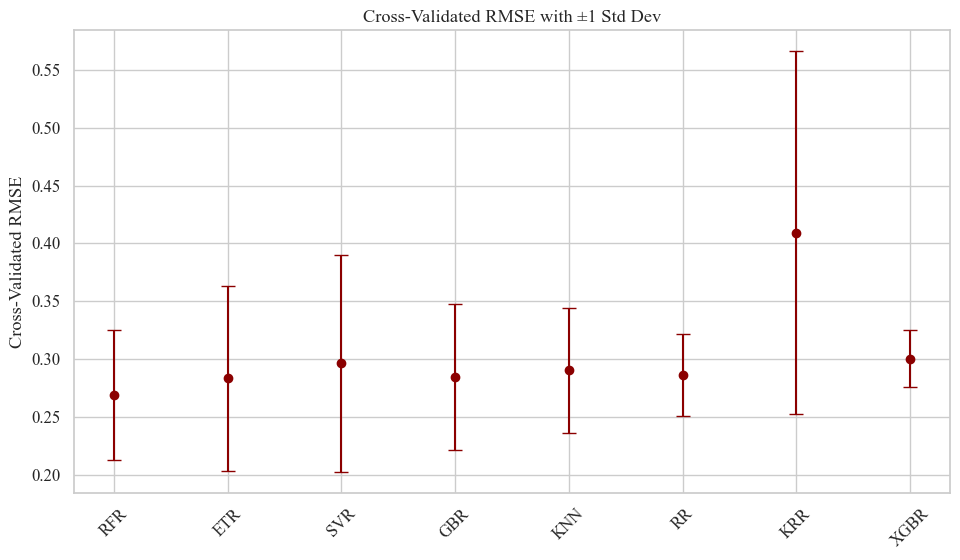


✅ Best model based on Test RMSE: ETR


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Load data
data = pd.read_csv('data.txt', sep="\s+", index_col=0)
X = data.drop(columns=["$E_a$"])
y = data["$E_a$"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "RFR": RandomForestRegressor(n_estimators=100, random_state=42),
    "ETR": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(C=100, kernel='rbf'),
    "GBR": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RR": Ridge(alpha=1.0),
    "KRR": KernelRidge(alpha=1.0, kernel='rbf'),
    "XGBR": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Store results
results = []

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_test = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)

    # Metrics
    rmse_test = rmse(y_test, y_pred_test)
    rmse_train = rmse(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    # Cross-validation (on train data)
    rmse_cv = -cross_val_score(model, X_train_scaled, y_train, scoring=rmse_scorer, cv=5)
    r2_cv = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=5)

    results.append({
        "Model": name,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "RMSE_CV_Mean": rmse_cv.mean(),
        "RMSE_CV_STD": rmse_cv.std(),
        "R2_CV_Mean": r2_cv.mean(),
        "R2_CV_STD": r2_cv.std()
    })

results_df = pd.DataFrame(results)

# Sort by RMSE_Test for best model highlight
results_df_sorted_rmse = results_df.sort_values("RMSE_Test")
best_model = results_df_sorted_rmse.iloc[0]["Model"]

# --- PLOTS ---
sns.set(style="whitegrid", font_scale=1.1)

# R2 Comparison: Train vs Test
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
results_df_sorted = results_df.sort_values("R2_Test", ascending=False)
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Test"], color='seagreen', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Train"], color='lightgreen', alpha=0.6, label="Train")
plt.xlabel("R² Score")
plt.title("R² Score Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE Comparison: Train vs Test
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
results_df_sorted = results_df.sort_values("RMSE_Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Test"], color='firebrick', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Train"], color='salmon', alpha=0.6, label="Train")
plt.xlabel("RMSE")
plt.title("RMSE Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Cross-Validated R² Scores with Error Bars
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.errorbar(results_df["Model"], results_df["R2_CV_Mean"], yerr=results_df["R2_CV_STD"], fmt='o', color='mediumblue', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated R²")
plt.title("Cross-Validated R² with ±1 Std Dev")
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.tight_layout()
plt.show()

# Cross-Validated RMSE Scores with Error Bars
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.errorbar(results_df["Model"], results_df["RMSE_CV_Mean"], yerr=results_df["RMSE_CV_STD"], fmt='o', color='darkred', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated RMSE")
plt.title("Cross-Validated RMSE with ±1 Std Dev")
plt.tight_layout()
plt.show()

# Print best model
print(f"\n✅ Best model based on Test RMSE: {best_model}")



🔍 SHAP analysis for best model: ETR


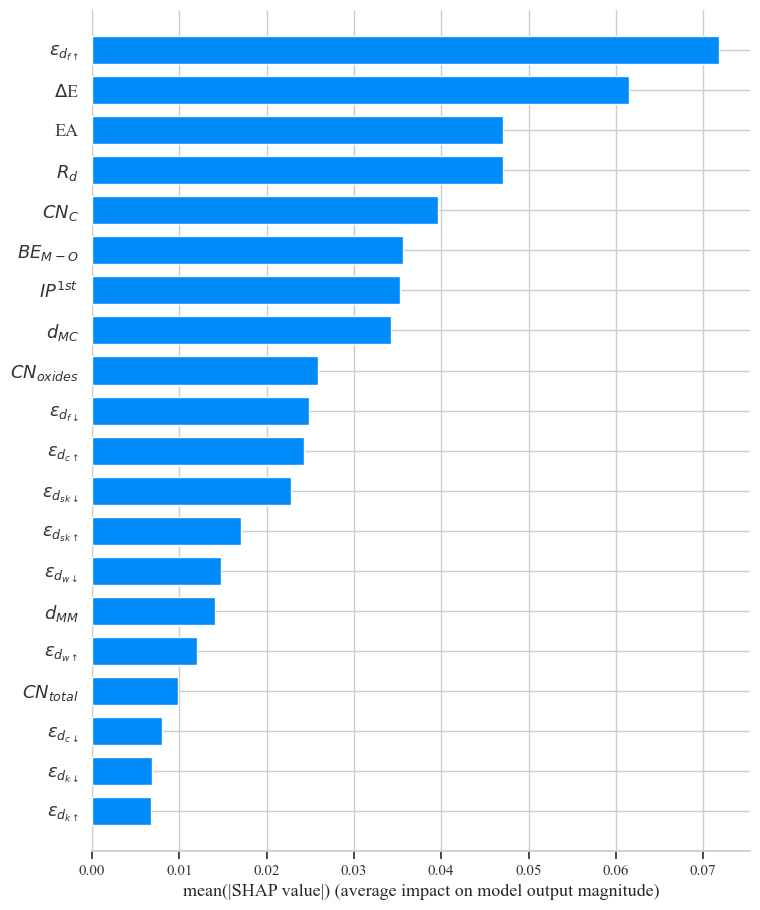

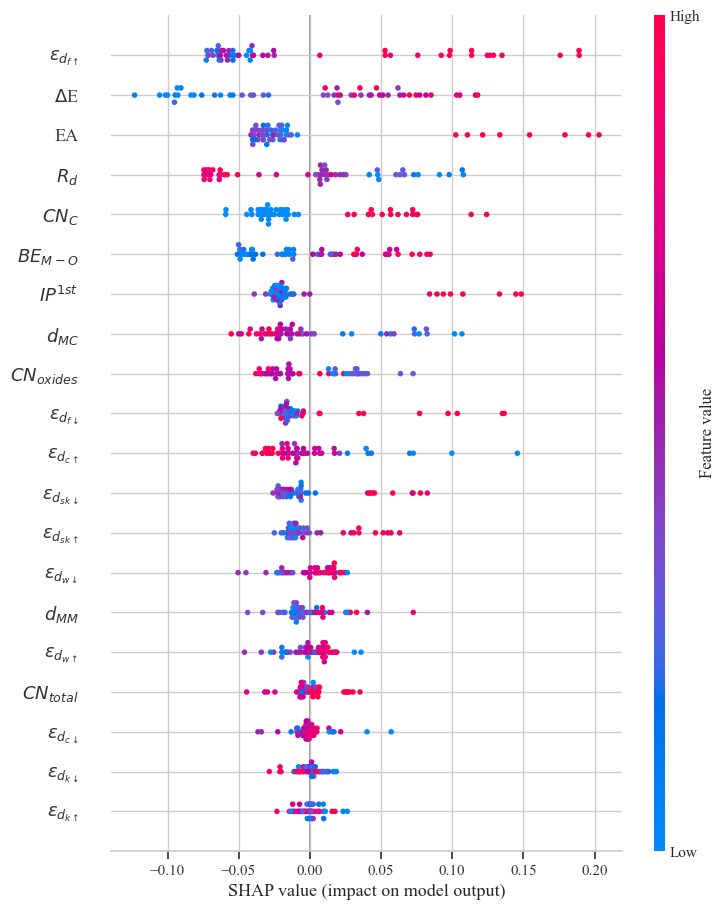

In [2]:
import shap
# Select best model (already sorted by lowest RMSE)
best_model_name = results_df.sort_values("RMSE_Test").iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\n🔍 SHAP analysis for best model: {best_model_name}")

# Use X_train_scaled and feature names for SHAP
feature_names = X.columns.tolist()

# Tree-based models: use TreeExplainer
if best_model_name in ["RFR", "ETR", "GBR", "XGBR"]:
    explainer = shap.Explainer(best_model, X_train_scaled, feature_names=feature_names)
    shap_values = explainer(X_train_scaled)

    # Summary Plot
    shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names, plot_type="bar")
    shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names)
    
else:
    # For non-tree models, use KernelExplainer (slow)
    background = shap.kmeans(X_train_scaled, 10)
    explainer = shap.KernelExplainer(best_model.predict, background)
    shap_values = explainer.shap_values(X_train_scaled[:100])  # subset for speed

    shap.summary_plot(shap_values, features=X_train_scaled[:100], feature_names=feature_names, plot_type="bar")
    shap.summary_plot(shap_values, features=X_train_scaled[:100], feature_names=feature_names)


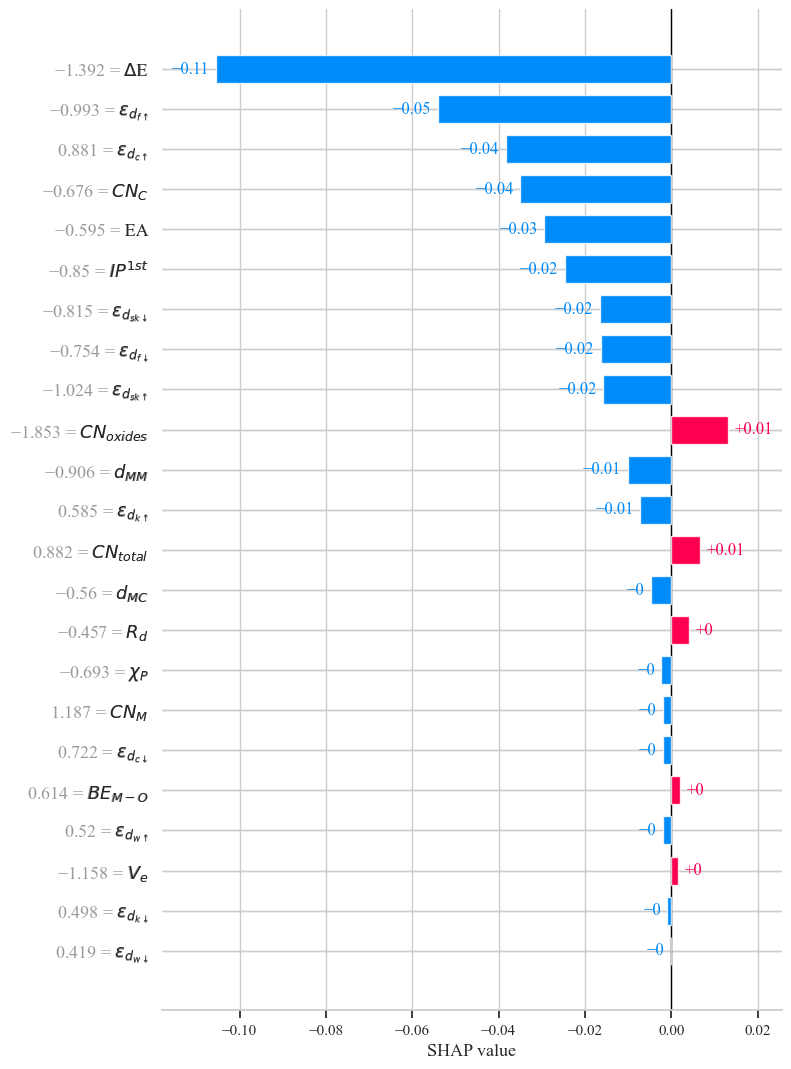

In [21]:
shap.plots.bar(shap_values[0], max_display=23, show=True)

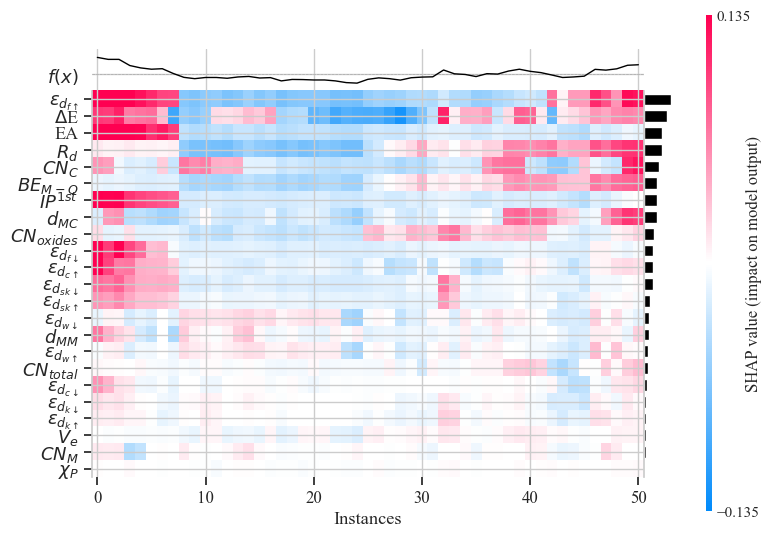

<Figure size 640x480 with 0 Axes>

In [7]:
shap.plots.heatmap(shap_values[:1000], max_display=23, show=True)
plt.tight_layout()
plt.savefig('shap_heatmap.png', dpi=300, bbox_inches='tight')

In [16]:
import shap
shap.initjs()
shap.plots.force(shap_values[12])

In [20]:
import os
# Create folder for SHAP plots
os.makedirs("shap_plots", exist_ok=True)

# Select best model
best_model_name = results_df.sort_values("RMSE_Test").iloc[0]["Model"]
best_model = models[best_model_name]

print(f"\n🔍 SHAP analysis for best model: {best_model_name}")

# Use original feature names
feature_names = X.columns.tolist()

# Tree-based model: use TreeExplainer
if best_model_name in ["RFR", "ETR", "GBR", "XGBR"]:
    explainer = shap.Explainer(best_model, X_train_scaled, feature_names=feature_names)
    shap_values = explainer(X_train_scaled)

    # Summary plot (bar)
    shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names, plot_type="bar", show=False, max_display=23)
    plt.title(f"SHAP Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.savefig("shap_plots/summary_bar.png", bbox_inches='tight', dpi=300)
    plt.close()

    # Summary plot (beeswarm)
    shap.summary_plot(shap_values, features=X_train_scaled, feature_names=feature_names, show=False, max_display=23)
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    plt.tight_layout()
    plt.savefig("shap_plots/summary_beeswarm.png", bbox_inches='tight', dpi=300)
    plt.close()

    # Waterfall plot for 1 sample
    idx = 0
    shap.plots.waterfall(shap_values[idx], max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot (Sample {idx})")
    plt.tight_layout()
    plt.savefig(f"shap_plots/waterfall_sample_{idx}.png", bbox_inches='tight', dpi=300)
    plt.close()

    print("✅ SHAP plots saved to `shap_plots/` folder")

else:
    # KernelExplainer for non-tree models (slower)
    background = shap.kmeans(X_train_scaled, 10)
    explainer = shap.KernelExplainer(best_model.predict, background)
    shap_values = explainer.shap_values(X_train_scaled[:100])  # Subset for speed

    # Summary bar
    shap.summary_plot(shap_values, features=X_train_scaled[:100], feature_names=feature_names, plot_type="bar", show=False, max_display=23)
    plt.title(f"SHAP Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.savefig("shap_plots/summary_bar.png", bbox_inches='tight', dpi=300)
    plt.close()

    # Beeswarm
    shap.summary_plot(shap_values, features=X_train_scaled[:100], feature_names=feature_names, show=False, max_display=23)
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    plt.tight_layout()
    plt.savefig("shap_plots/summary_beeswarm.png", bbox_inches='tight', dpi=300)
    plt.close()

    print("✅ SHAP plots saved to `shap_plots/` folder (subset only due to performance)")


🔍 SHAP analysis for best model: ETR
✅ SHAP plots saved to `shap_plots/` folder


In [58]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(64, 32),  # Two hidden layers
                  activation='relu',
                  solver='adam',
                  alpha=0.001,  # L2 penalty
                  learning_rate='adaptive',
                  max_iter=1000,
                  random_state=42)

nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)

rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network RMSE: {rmse_nn:.3f}")
print(f"Neural Network R²: {r2_nn:.3f}")


Neural Network RMSE: 0.322
Neural Network R²: 0.490


In [60]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate': ['adaptive'],
    'max_iter': [1000]
}

# Grid search setup
mlp = MLPRegressor(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score (CV):", grid_search.best_score_)

# Predict and evaluate
y_pred_grid = grid_search.predict(X_test_scaled)
print("Test R2:", r2_score(y_test, y_pred_grid))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_grid)))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10

[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(128,), learning_rate=adaptive, max_iter=1000; total time=   0.0s
[CV] END acti

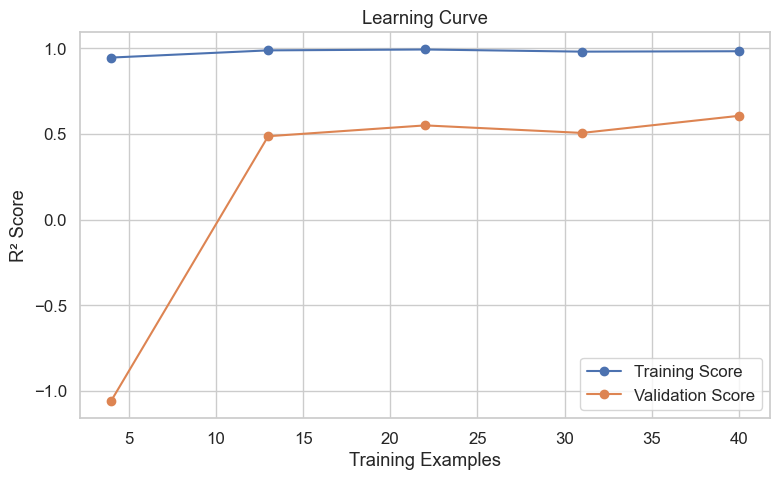

In [61]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')
    plt.xlabel("Training Examples")
    plt.ylabel("R² Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Use best model from grid search
plot_learning_curve(grid_search.best_estimator_, X_train_scaled, y_train)


In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
def build_keras_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_keras_model(X_train_scaled.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200


/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5283 - mae: 1.0430 - val_loss: 0.4820 - val_mae: 0.5020
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0472 - mae: 0.7689 - val_loss: 0.2703 - val_mae: 0.4413
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4667 - mae: 0.5119 - val_loss: 0.2230 - val_mae: 0.4450
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4084 - mae: 0.4979 - val_loss: 0.1982 - val_mae: 0.3879
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3943 - mae: 0.4987 - val_loss: 0.1674 - val_mae: 0.3213
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2958 - mae: 0.4449 - val_loss: 0.1318 - val_mae: 0.2667
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3525 - mae: 0.4544 - val_loss: 0.1014 - val_mae: 0.2217
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2737 - mae: 0.4216 - val_loss: 0.0863 - val_mae: 0.2347
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2607 - mae: 0.3896 - val

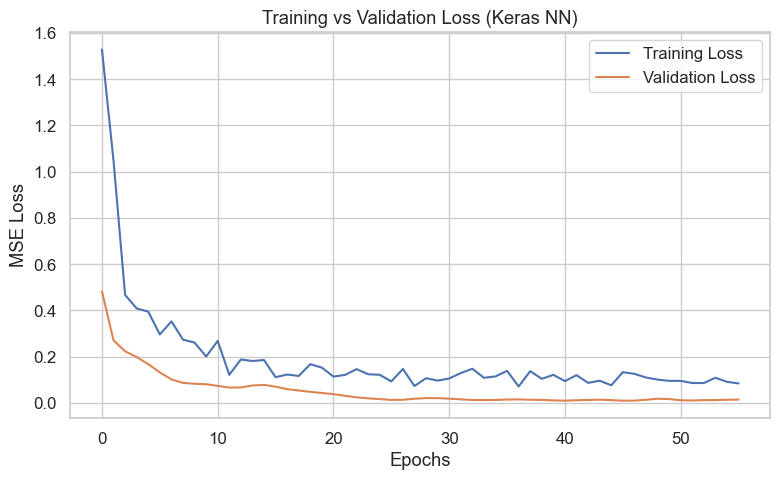

In [63]:
def plot_keras_history(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Training vs Validation Loss (Keras NN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_keras_history(history)


/var/folders/6v/j0sj4tjs3079tx36_q0xfrrh0000gn/T/ipykernel_82346/363507299.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:100], show=True)


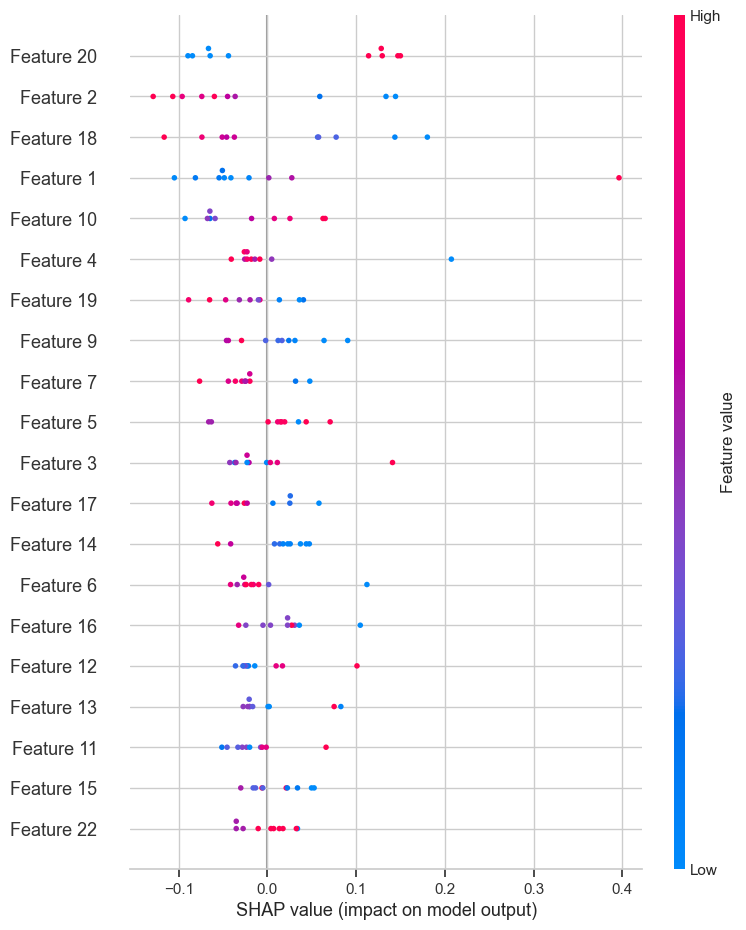

In [64]:
import shap

# Use DeepExplainer or KernelExplainer
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100])  # SHAP on a subset for speed

shap.summary_plot(shap_values, X_test.iloc[:100], show=True)


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Load data
data = pd.read_csv('data.txt', sep="\s+", index_col=0)
X = data.drop(columns=["$E_a$"])
y = data["$E_a$"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "RFR": RandomForestRegressor(n_estimators=100, random_state=42),
    "ETR": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(C=100, kernel='rbf'),
    "GBR": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "RR": Ridge(alpha=1.0),
    "KRR": KernelRidge(alpha=1.0, kernel='rbf'),
    "XGBR": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Store results
results = []

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_test = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)

    # Metrics
    rmse_test = rmse(y_test, y_pred_test)
    rmse_train = rmse(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    # Cross-validation (on train data)
    rmse_cv = -cross_val_score(model, X_train_scaled, y_train, scoring=rmse_scorer, cv=5)
    r2_cv = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=5)

    results.append({
        "Model": name,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "RMSE_CV_Mean": rmse_cv.mean(),
        "RMSE_CV_STD": rmse_cv.std(),
        "R2_CV_Mean": r2_cv.mean(),
        "R2_CV_STD": r2_cv.std()
    })

results_df = pd.DataFrame(results)

# Sort by RMSE_Test for best model highlight
results_df_sorted_rmse = results_df.sort_values("RMSE_Test")
best_model = results_df_sorted_rmse.iloc[0]["Model"]

# R2 Comparison: Train vs Test
plt.figure(figsize=(6, 6))
results_df_sorted = results_df.sort_values("R2_Test", ascending=False)
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Test"], color='seagreen', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Train"], color='lightgreen', alpha=0.6, label="Train")
plt.xlabel("R² Score", fontsize=18)
plt.title("R² Score Comparison (Train vs Test)", fontsize=18)
plt.legend()
plt.tight_layout()
plt.grid(False)
#plt.show()
plt.savefig("r2_comparison.png", bbox_inches='tight', dpi=300)

# RMSE Comparison: Train vs Test
plt.figure(figsize=(6, 6))
results_df_sorted = results_df.sort_values("RMSE_Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Test"], color='seagreen', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Train"], color='lightgreen', alpha=0.6, label="Train")
plt.xlabel("RMSE", fontsize=18)
plt.title("RMSE Comparison (Train vs Test)", fontsize=18)
plt.legend()
plt.tight_layout()
plt.grid(False)
#plt.show()
plt.savefig("rmse_comparison.png", bbox_inches='tight', dpi=300)

# Print best model
print(f"\n✅ Best model based on Test RMSE: {best_model}")



✅ Best model based on Test RMSE: ETR


/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


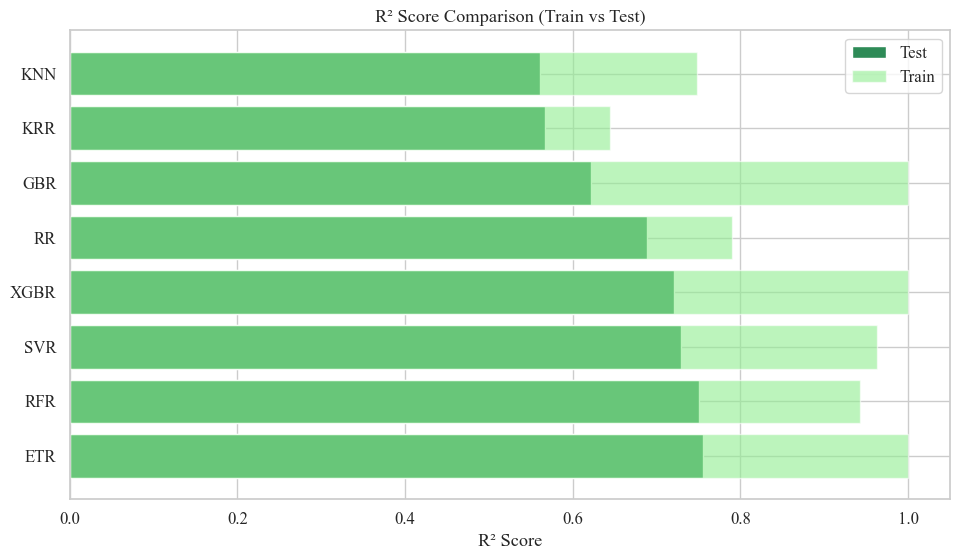

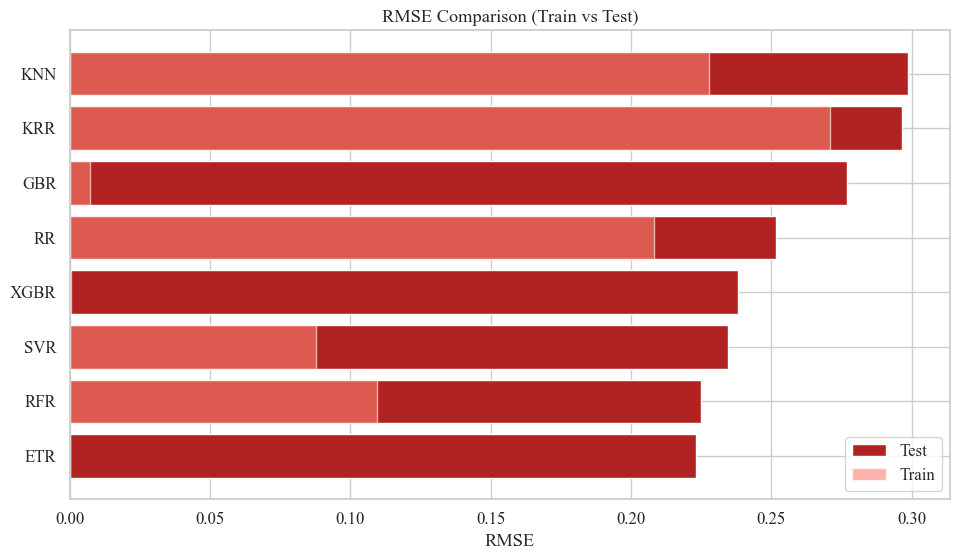

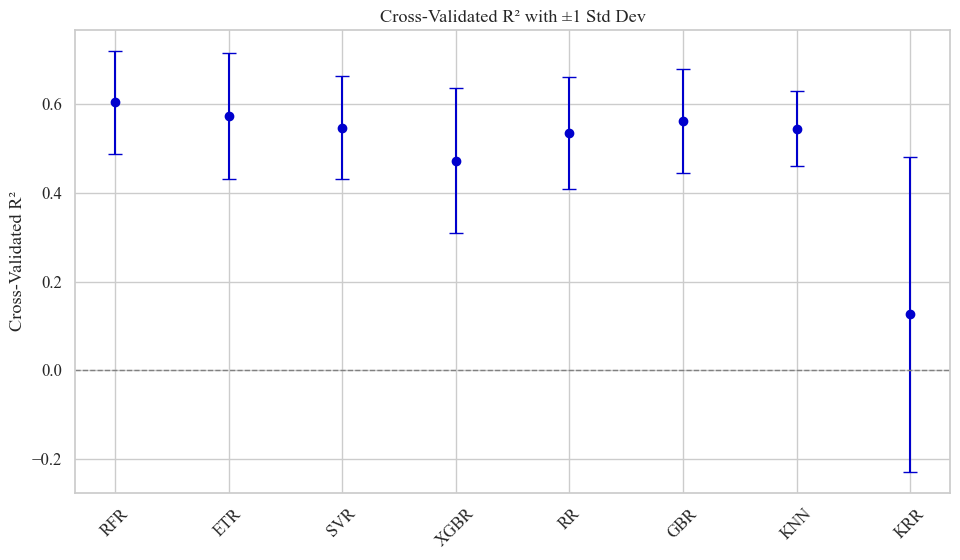

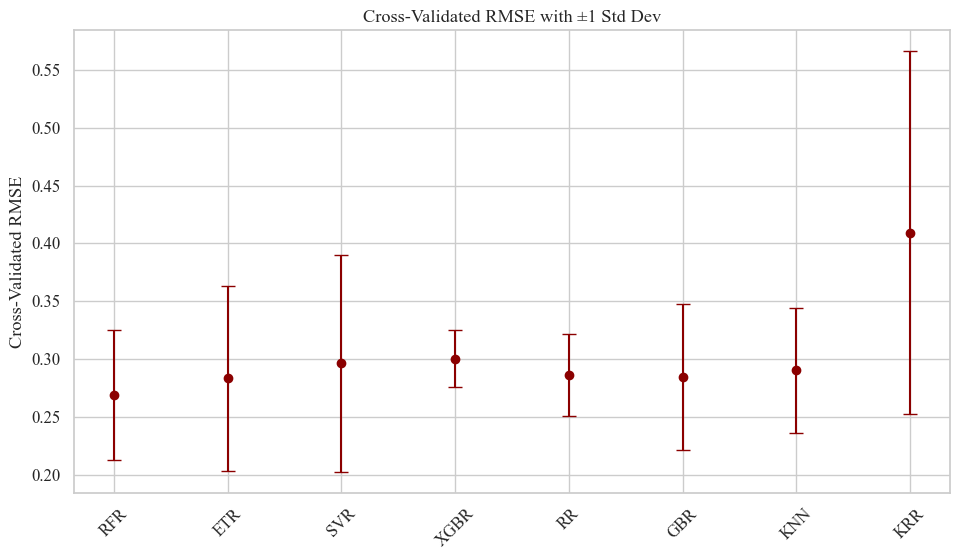


✅ Best model based on Test RMSE: ETR


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Load data
data = pd.read_csv('data.txt', sep="\s+", index_col=0)
X = data.drop(columns=["$E_a$"])
y = data["$E_a$"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "RFR": RandomForestRegressor(n_estimators=100, random_state=42),
    "ETR": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(C=100, kernel='rbf'),
    "XGBR": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "RR": Ridge(alpha=1.0),
    "GBR": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "KRR": KernelRidge(alpha=1.0, kernel='rbf')
}

# Store results
results = []

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_test = model.predict(X_test_scaled)
    y_pred_train = model.predict(X_train_scaled)

    # Metrics
    rmse_test = rmse(y_test, y_pred_test)
    rmse_train = rmse(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    # Cross-validation (on train data)
    rmse_cv = -cross_val_score(model, X_train_scaled, y_train, scoring=rmse_scorer, cv=5)
    r2_cv = cross_val_score(model, X_train_scaled, y_train, scoring='r2', cv=5)

    results.append({
        "Model": name,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "RMSE_CV_Mean": rmse_cv.mean(),
        "RMSE_CV_STD": rmse_cv.std(),
        "R2_CV_Mean": r2_cv.mean(),
        "R2_CV_STD": r2_cv.std()
    })

results_df = pd.DataFrame(results)

# Sort by RMSE_Test for best model highlight
results_df_sorted_rmse = results_df.sort_values("RMSE_Test")
best_model = results_df_sorted_rmse.iloc[0]["Model"]

# --- PLOTS ---
sns.set(style="whitegrid", font_scale=1.1)

# R2 Comparison: Train vs Test
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
results_df_sorted = results_df.sort_values("R2_Test", ascending=False)
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Test"], color='seagreen', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Train"], color='lightgreen', alpha=0.6, label="Train")
plt.xlabel("R² Score")
plt.title("R² Score Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE Comparison: Train vs Test
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
results_df_sorted = results_df.sort_values("RMSE_Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Test"], color='firebrick', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Train"], color='salmon', alpha=0.6, label="Train")
plt.xlabel("RMSE")
plt.title("RMSE Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Cross-Validated R² Scores with Error Bars
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.errorbar(results_df["Model"], results_df["R2_CV_Mean"], yerr=results_df["R2_CV_STD"], fmt='o', color='mediumblue', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated R²")
plt.title("Cross-Validated R² with ±1 Std Dev")
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.tight_layout()
plt.show()

# Cross-Validated RMSE Scores with Error Bars
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.errorbar(results_df["Model"], results_df["RMSE_CV_Mean"], yerr=results_df["RMSE_CV_STD"], fmt='o', color='darkred', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated RMSE")
plt.title("Cross-Validated RMSE with ±1 Std Dev")
plt.tight_layout()
plt.show()

# Print best model
print(f"\n✅ Best model based on Test RMSE: {best_model}")


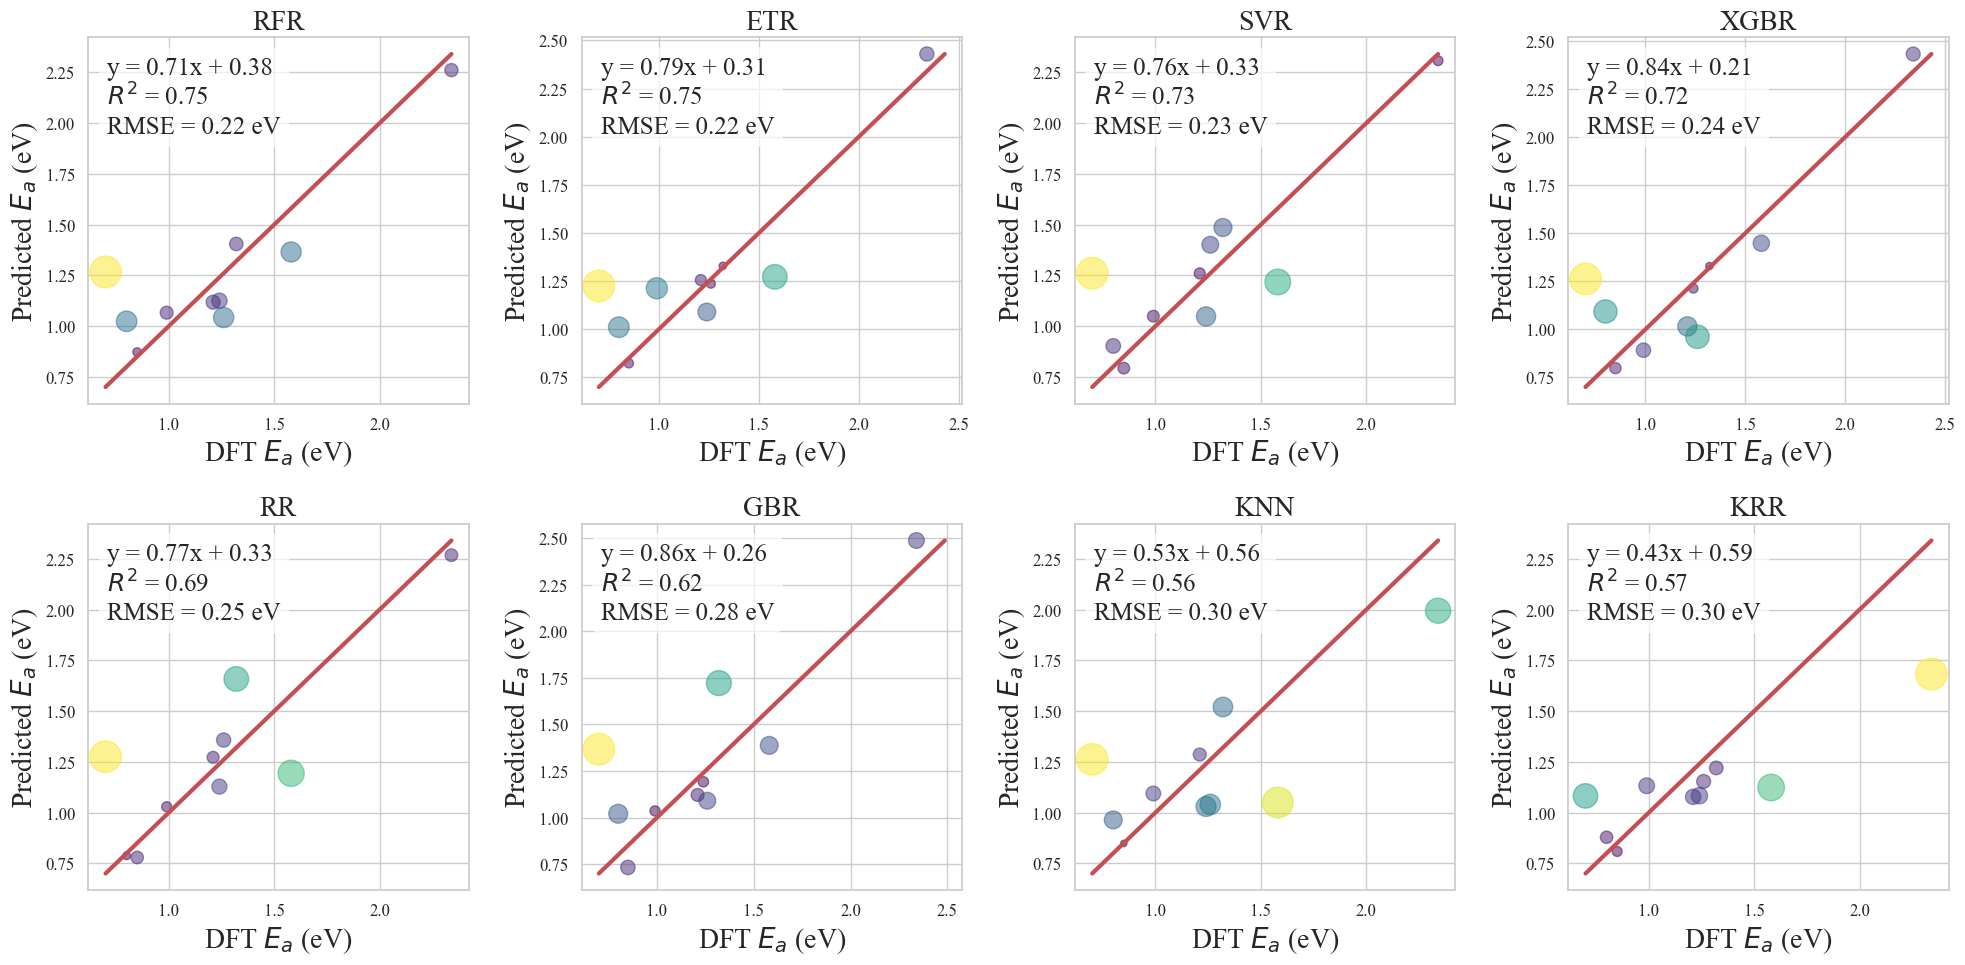

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set global font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# Create subplots grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate influence scores using residuals
    residuals = np.abs(y_test - y_pred)
    influence = residuals / residuals.max()
    marker_sizes = 20 + 500 * influence
    
    # Create scatter plot
    scatter = axes[idx].scatter(y_test, y_pred, s=marker_sizes, alpha=0.5, 
                              c=influence, cmap='viridis')
    
    # Add diagonal line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=3)
    
    # Add equation and metrics
    equation = f'y = {np.polyfit(y_test, y_pred, 1)[0]:.2f}x + {np.polyfit(y_test, y_pred, 1)[1]:.2f}'
    stats_text = f'{equation}\n$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} eV'
    axes[idx].text(0.05, 0.95, stats_text,
                  transform=axes[idx].transAxes,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Labels
    axes[idx].set_xlabel('DFT $E_a$ (eV)', fontsize=20)
    axes[idx].set_ylabel('Predicted $E_a$ (eV)', fontsize=20)
    axes[idx].set_title(name, fontsize=20)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



🔍 Optimizing RR ...


/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sweetstark/miniforge3/envs/p39/lib/python3.10

✅ Best params for RR: {'alpha': 10.0}

🔍 Optimizing XGBR ...
✅ Best params for XGBR: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}

🔍 Optimizing RFR ...
✅ Best params for RFR: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

🔍 Optimizing ETR ...
✅ Best params for ETR: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}

🔍 Optimizing SVR ...
✅ Best params for SVR: {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}

🔍 Optimizing KNN ...
✅ Best params for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

🔍 Optimizing GBR ...
✅ Best params for GBR: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}

🔍 Optimizing KRR ...
✅ Best params for KRR: {'alpha': 1.0, 'gamma': 0.1, 'kernel': 'polynomial'}


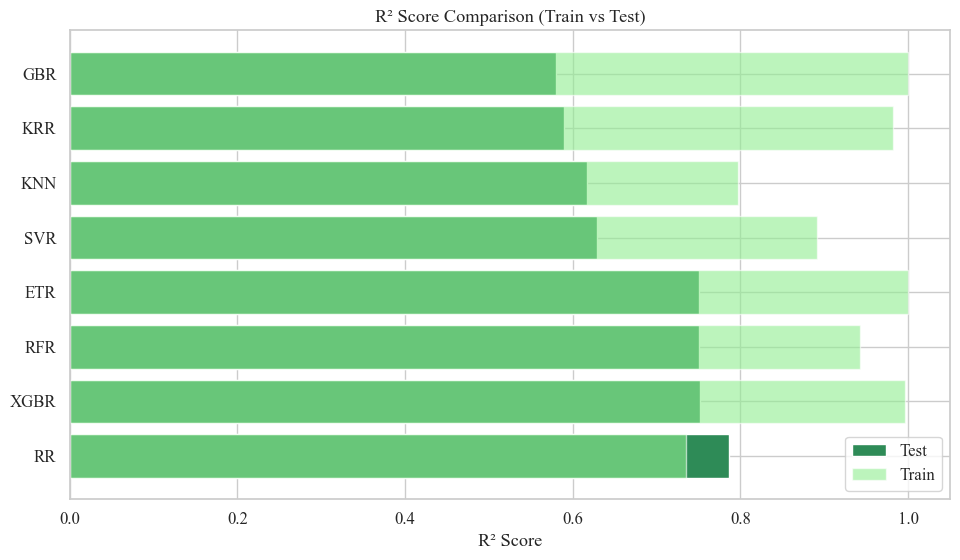

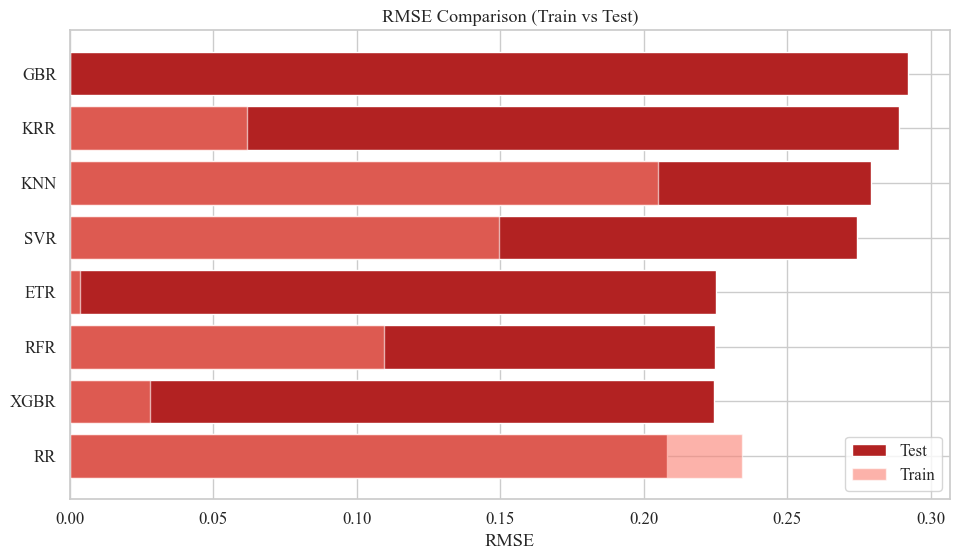

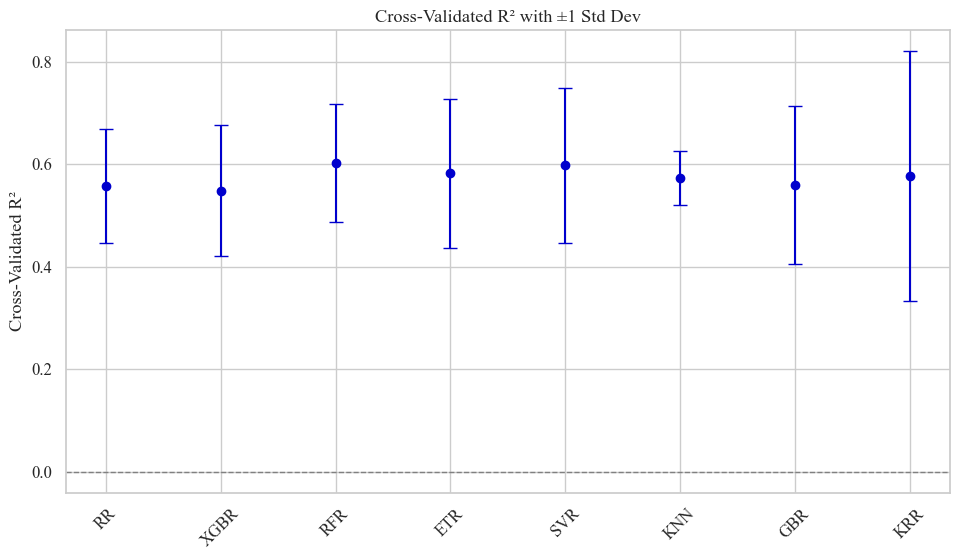

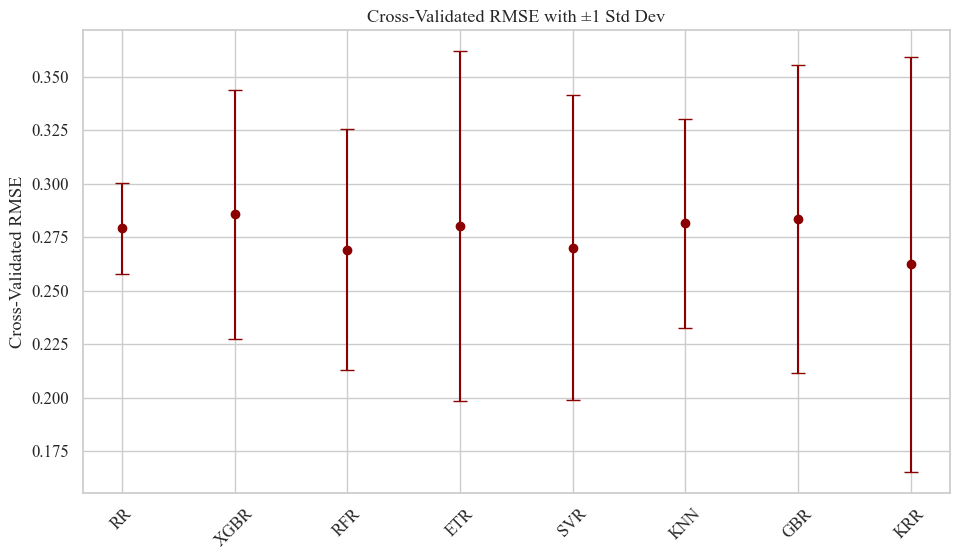


🏆 Best model: RR with params {'alpha': 10.0}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Load data
data = pd.read_csv('data.txt', sep="\s+", index_col=0)
X = data.drop(columns=["$E_a$"])
y = data["$E_a$"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# --- Hyperparameter grids ---
param_grids = {
    "RFR": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "ETR": {
        "n_estimators": [100, 300, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "SVR": {
        "C": [1, 10, 100],
        "gamma": ['scale', 0.01, 0.1, 1],
        "kernel": ['rbf', 'poly']
    },
    "XGBR": {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0]
    },
    "RR": {
        "alpha": [0.1, 1.0, 10.0, 100.0]
    },
    "GBR": {
        "n_estimators": [100, 300, 500],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9],
        "weights": ['uniform', 'distance'],
        "p": [1, 2]  # Manhattan, Euclidean
    },
    "KRR": {
        "alpha": [0.01, 0.1, 1.0, 10.0],
        "kernel": ['linear', 'rbf', 'polynomial'],
        "gamma": [0.01, 0.1, 1.0]
    }
}

# Base models (without params)
base_models = {
    "RR": Ridge(),
    "XGBR": XGBRegressor(random_state=42, verbosity=0),
    "RFR": RandomForestRegressor(random_state=42),
    "ETR": ExtraTreesRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "GBR": GradientBoostingRegressor(random_state=42),
    "KRR": KernelRidge()
}

# Store results
results = []

# --- Hyperparameter optimization loop ---
for name, model in base_models.items():
    print(f"\n🔍 Optimizing {name} ...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=rmse_scorer,
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    print(f"✅ Best params for {name}: {grid.best_params_}")

    # Predict
    y_pred_test = best_model.predict(X_test_scaled)
    y_pred_train = best_model.predict(X_train_scaled)

    # Metrics
    rmse_test = rmse(y_test, y_pred_test)
    rmse_train = rmse(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    # Cross-validation (with best model)
    rmse_cv = -cross_val_score(best_model, X_train_scaled, y_train, scoring=rmse_scorer, cv=5)
    r2_cv = cross_val_score(best_model, X_train_scaled, y_train, scoring='r2', cv=5)

    results.append({
        "Model": name,
        "Best_Params": grid.best_params_,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "RMSE_CV_Mean": rmse_cv.mean(),
        "RMSE_CV_STD": rmse_cv.std(),
        "R2_CV_Mean": r2_cv.mean(),
        "R2_CV_STD": r2_cv.std()
    })

results_df = pd.DataFrame(results)

# --- PLOTS (same as before) ---
sns.set(style="whitegrid", font_scale=1.1)

# R² Comparison
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
results_df_sorted = results_df.sort_values("R2_Test", ascending=False)
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Test"], color='seagreen', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["R2_Train"], color='lightgreen', alpha=0.6, label="Train")
plt.xlabel("R² Score")
plt.title("R² Score Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE Comparison
plt.figure(figsize=(10, 6))
results_df_sorted = results_df.sort_values("RMSE_Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Test"], color='firebrick', label="Test")
plt.barh(results_df_sorted["Model"], results_df_sorted["RMSE_Train"], color='salmon', alpha=0.6, label="Train")
plt.xlabel("RMSE")
plt.title("RMSE Comparison (Train vs Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Cross-Validated R²
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Model"], results_df["R2_CV_Mean"], yerr=results_df["R2_CV_STD"], fmt='o', color='mediumblue', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated R²")
plt.title("Cross-Validated R² with ±1 Std Dev")
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.tight_layout()
plt.show()

# Cross-Validated RMSE
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Model"], results_df["RMSE_CV_Mean"], yerr=results_df["RMSE_CV_STD"], fmt='o', color='darkred', capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated RMSE")
plt.title("Cross-Validated RMSE with ±1 Std Dev")
plt.tight_layout()
plt.show()

# Print best model
best_model = results_df.sort_values("RMSE_Test").iloc[0]
print(f"\n🏆 Best model: {best_model['Model']} with params {best_model['Best_Params']}")


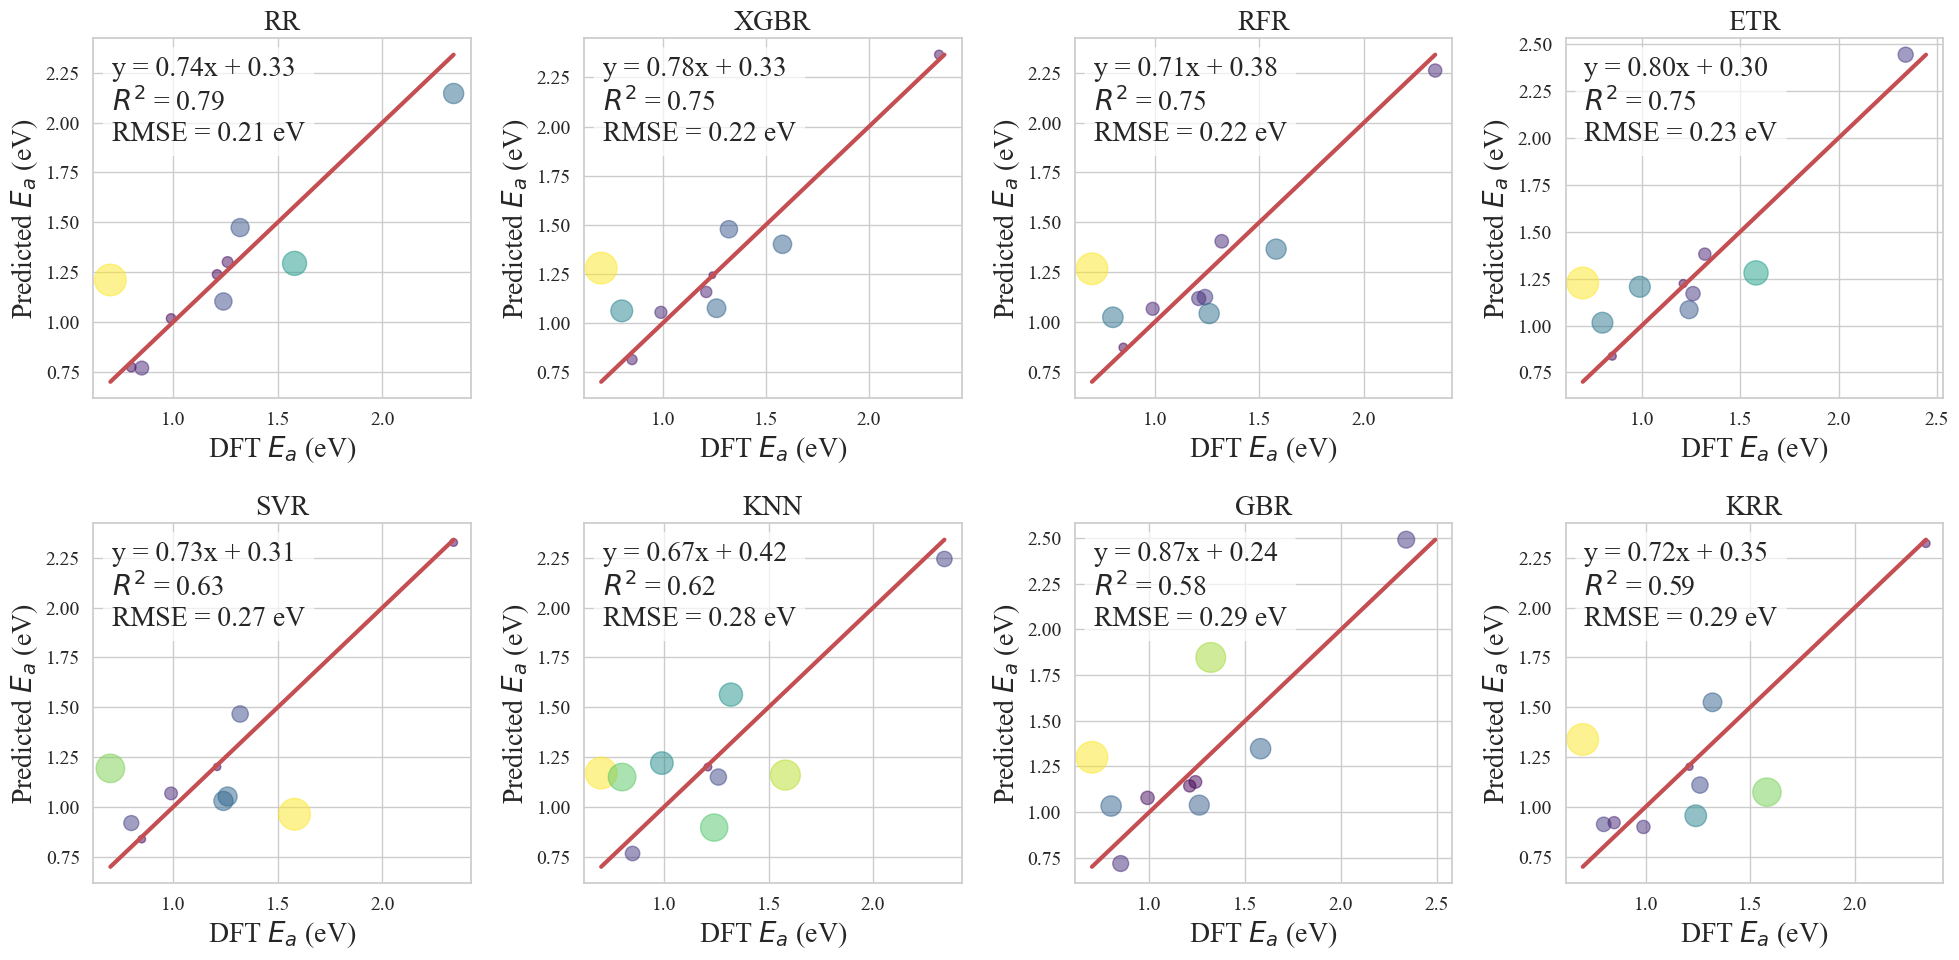

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Set global font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Create subplots grid (2 rows × 4 models = 8 models)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

# Loop over optimized models from results_df
for idx, row in enumerate(results_df.itertuples()):
    name = row.Model
    best_params = row.Best_Params
    model = base_models[name].set_params(**best_params)
    model.fit(X_train_scaled, y_train)

    # Get predictions
    y_pred = model.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Influence (based on residuals)
    residuals = np.abs(y_test - y_pred)
    influence = residuals / residuals.max()
    marker_sizes = 20 + 500 * influence

    # Scatter plot
    scatter = axes[idx].scatter(
        y_test, y_pred,
        s=marker_sizes, alpha=0.5,
        c=influence, cmap='viridis'
    )

    # Diagonal line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=3)

    # Equation & stats
    coef, intercept = np.polyfit(y_test, y_pred, 1)
    equation = f'y = {coef:.2f}x + {intercept:.2f}'
    stats_text = f'{equation}\n$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} eV'
    axes[idx].text(
        0.05, 0.95, stats_text,
        transform=axes[idx].transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

    # Labels
    axes[idx].set_xlabel('DFT $E_a$ (eV)', fontsize=20)
    axes[idx].set_ylabel('Predicted $E_a$ (eV)', fontsize=20)
    axes[idx].set_title(name, fontsize=20)
    axes[idx].tick_params(axis='both', labelsize=14)
    #plt.colorbar(scatter, orientation="horizontal")

#cbar = fig.colorbar(scatter, ax=axes, orientation="horizontal", location='bottom')
#cbar.set_label("Influence", fontsize=30)
#cbar.ax.tick_params(labelsize=25)
plt.tight_layout()
#plt.savefig('optimized_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

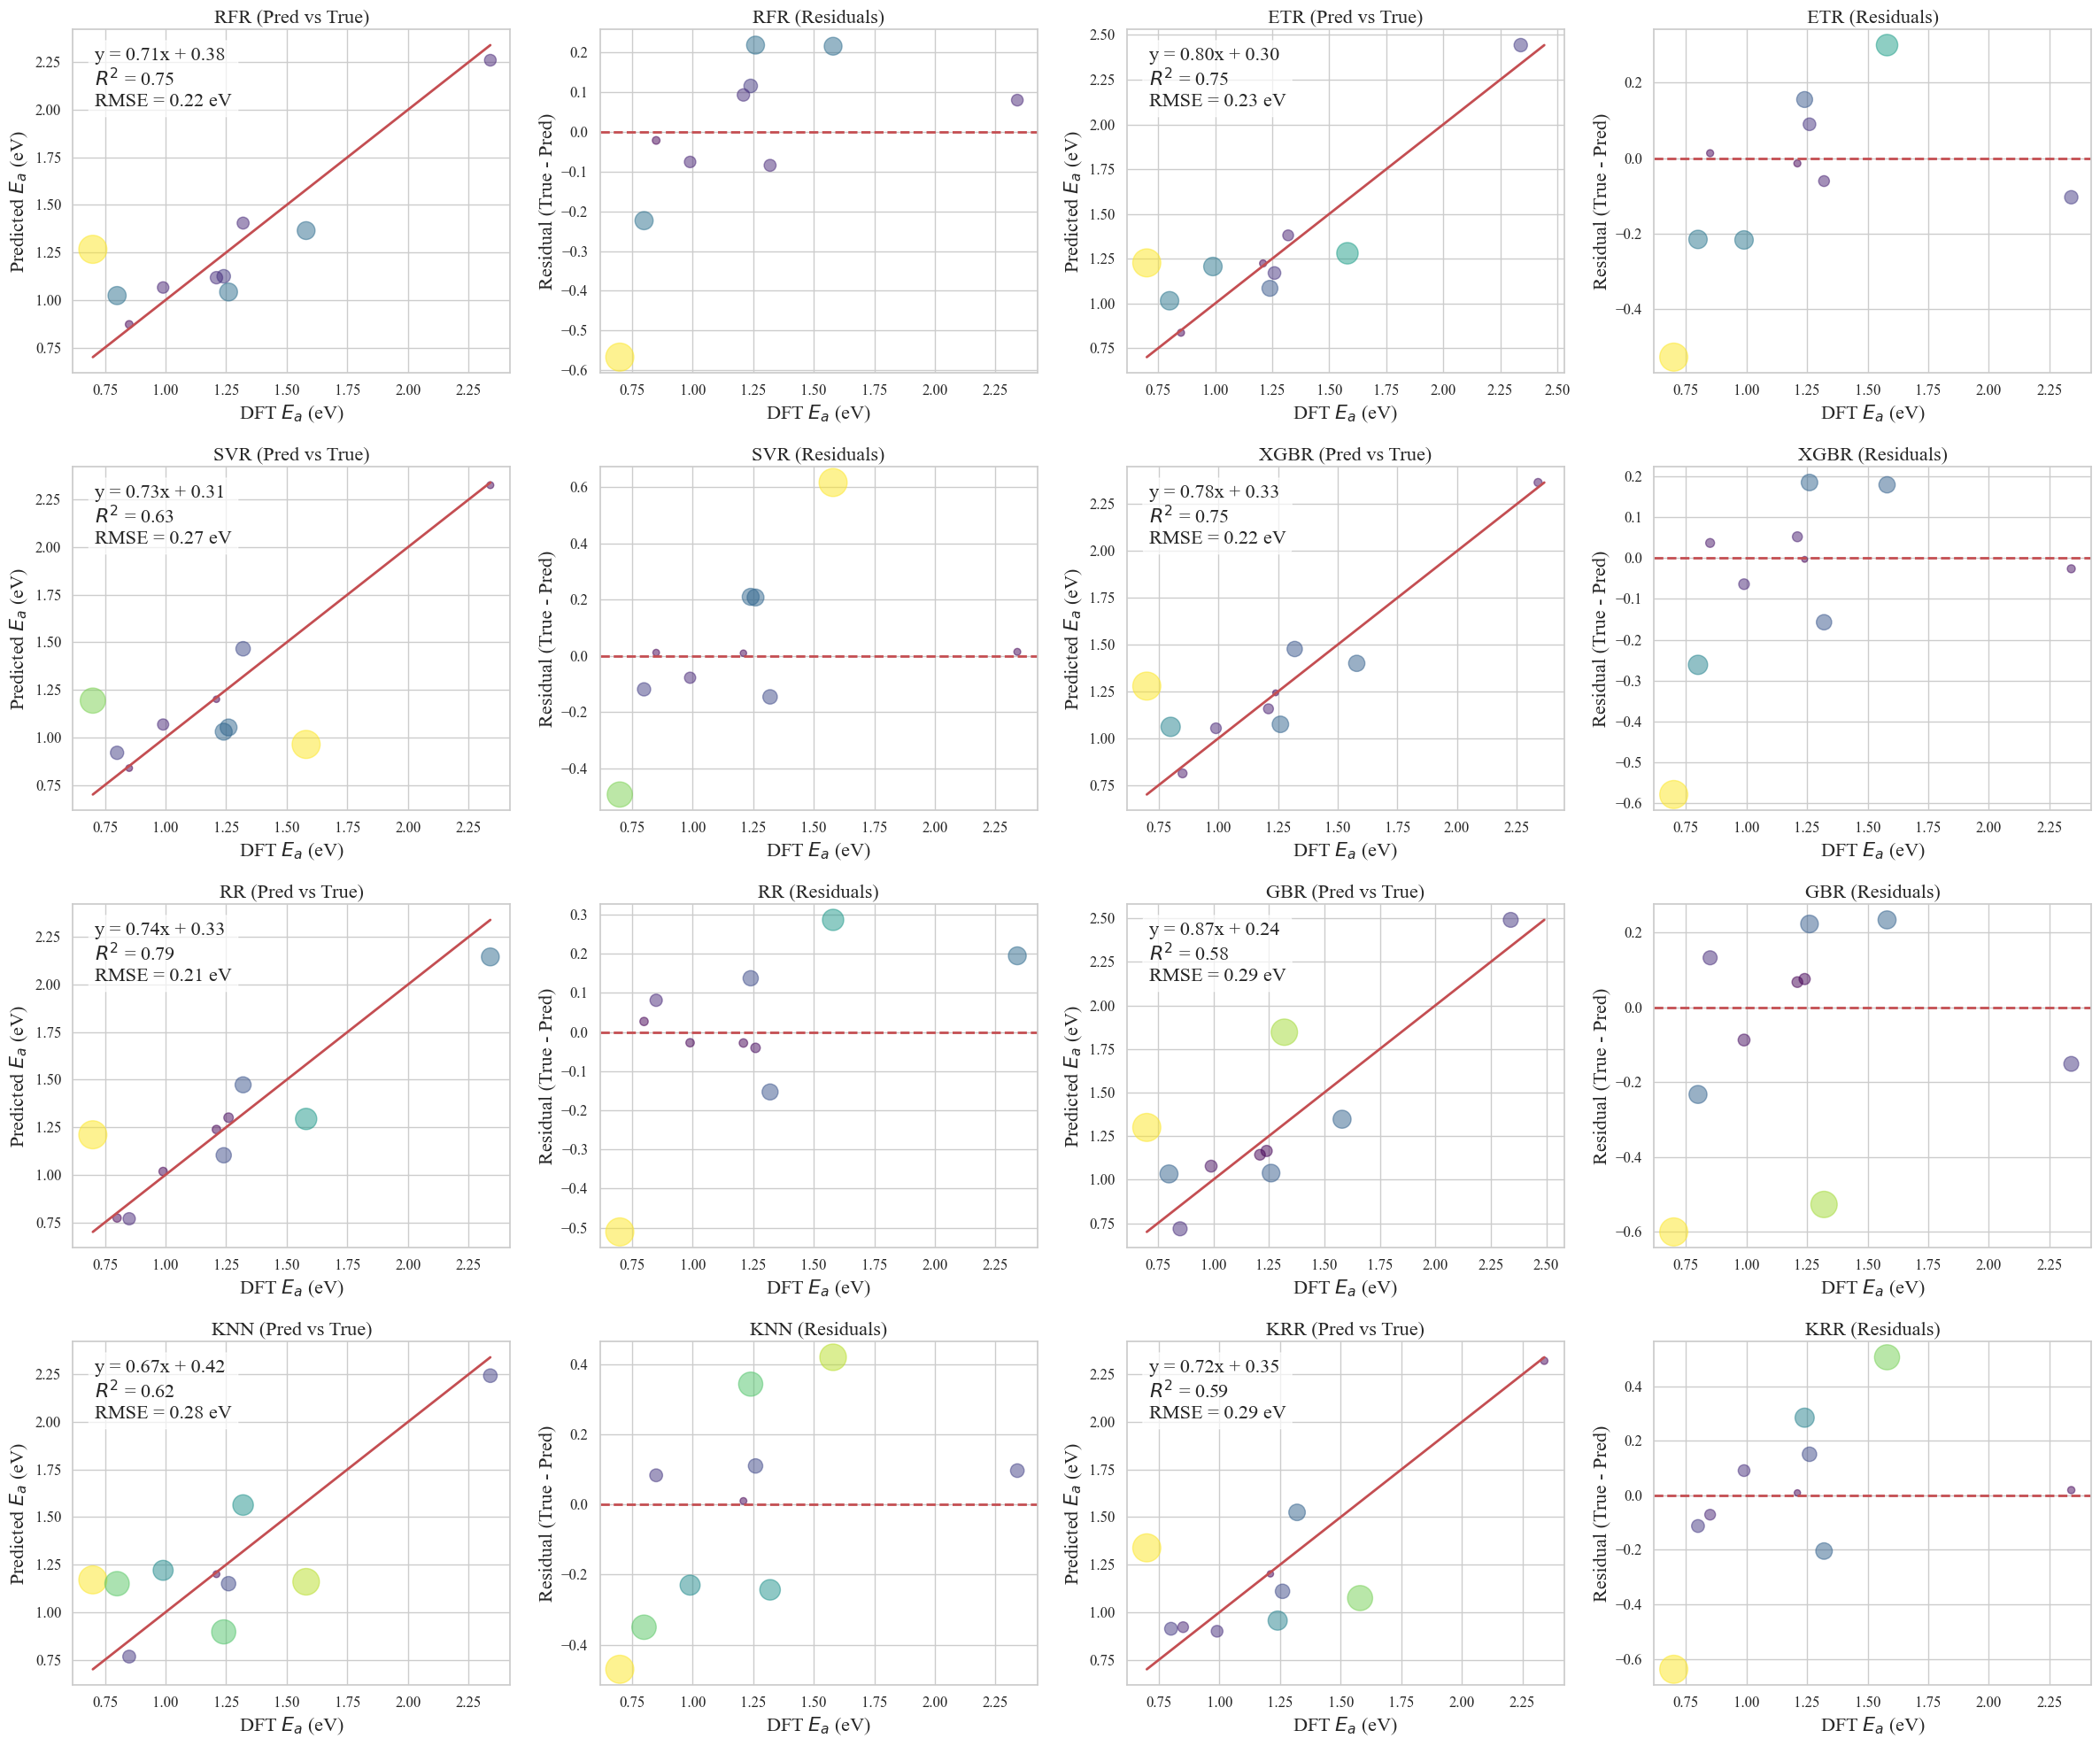

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set global font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16

# Create subplots grid (2 rows per model × 4 models = 8 models → 4×4 grid)
fig, axes = plt.subplots(4, 4, figsize=(24, 20))
axes = axes.ravel()

for idx, row in enumerate(results_df.itertuples()):
    name = row.Model
    best_params = row.Best_Params
    model = base_models[name].set_params(**best_params)
    model.fit(X_train_scaled, y_train)

    # Get predictions
    y_pred = model.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Influence (based on residuals)
    residuals = y_test - y_pred
    influence = np.abs(residuals) / np.abs(residuals).max()
    marker_sizes = 20 + 500 * influence

    # ---------- Scatter Plot (top row per model) ----------
    ax_scatter = axes[2 * idx]  # even indices
    scatter = ax_scatter.scatter(
        y_test, y_pred,
        s=marker_sizes, alpha=0.5,
        c=influence, cmap='viridis'
    )

    # Diagonal line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax_scatter.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=2)

    # Equation & stats
    coef, intercept = np.polyfit(y_test, y_pred, 1)
    equation = f'y = {coef:.2f}x + {intercept:.2f}'
    stats_text = f'{equation}\n$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f} eV'
    ax_scatter.text(
        0.05, 0.95, stats_text,
        transform=ax_scatter.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )

    ax_scatter.set_xlabel('DFT $E_a$ (eV)', fontsize=16)
    ax_scatter.set_ylabel('Predicted $E_a$ (eV)', fontsize=16)
    ax_scatter.set_title(f"{name} (Pred vs True)", fontsize=16)

    # ---------- Residual Plot (bottom row per model) ----------
    ax_resid = axes[2 * idx + 1]  # odd indices
    ax_resid.scatter(y_test, residuals, s=marker_sizes, alpha=0.5, c=influence, cmap='viridis')
    ax_resid.axhline(0, color='r', linestyle='--', linewidth=2)
    ax_resid.set_xlabel('DFT $E_a$ (eV)', fontsize=16)
    ax_resid.set_ylabel('Residual (True - Pred)', fontsize=16)
    ax_resid.set_title(f"{name} (Residuals)", fontsize=16)

plt.tight_layout()
plt.savefig('optimized_model_scatter_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


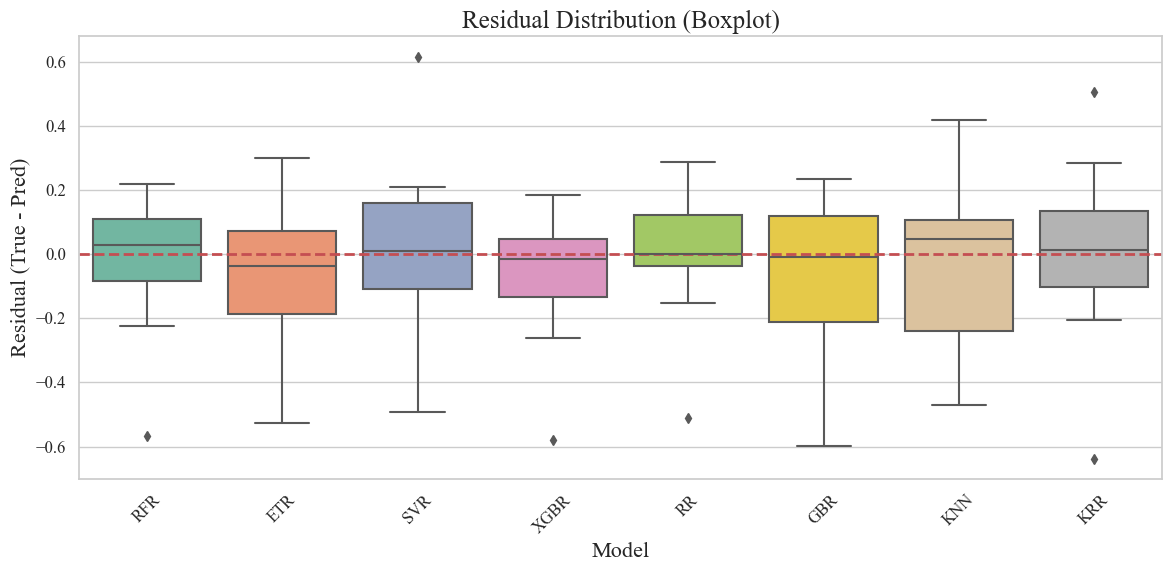

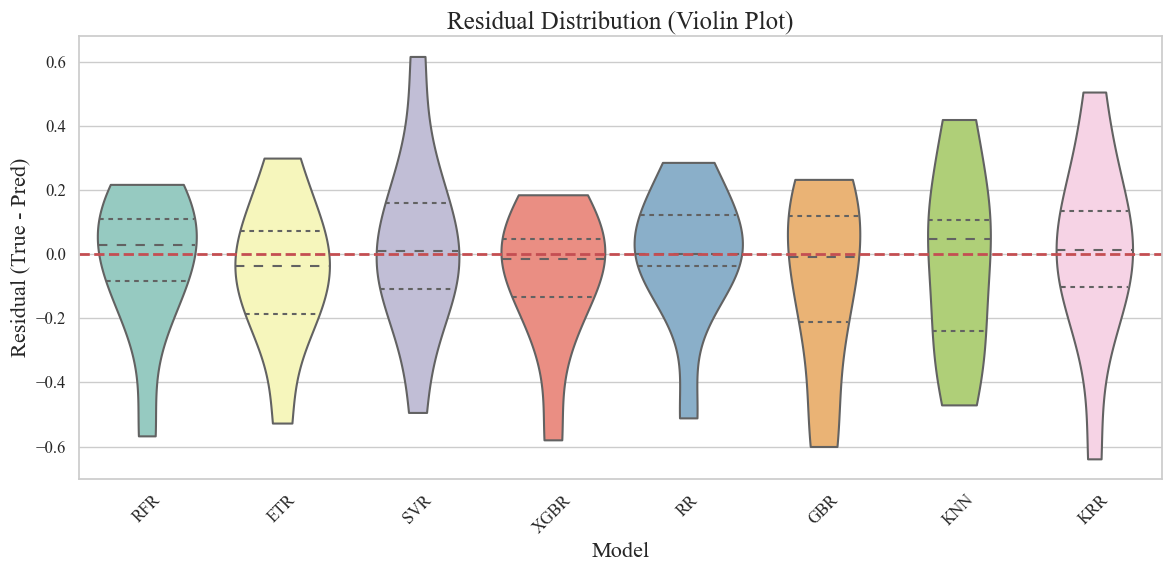

In [7]:
import seaborn as sns

# Collect residuals for distribution plots
residuals_dict = {}

for row in results_df.itertuples():
    name = row.Model
    best_params = row.Best_Params
    model = base_models[name].set_params(**best_params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    residuals_dict[name] = y_test - y_pred

# Convert to DataFrame (aligned by index for comparison)
residuals_df = pd.DataFrame(residuals_dict)

# --- Boxplot ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=residuals_df, palette="Set2")
plt.axhline(0, color="r", linestyle="--", linewidth=2)
plt.ylabel("Residual (True - Pred)", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.title("Residual Distribution (Boxplot)", fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("residual_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Violin plot ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=residuals_df, palette="Set3", cut=0, inner="quartile")
plt.axhline(0, color="r", linestyle="--", linewidth=2)
plt.ylabel("Residual (True - Pred)", fontsize=16)
plt.xlabel("Model", fontsize=16)
plt.title("Residual Distribution (Violin Plot)", fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("residual_violinplot.png", dpi=300, bbox_inches="tight")
plt.show()



🏆 Best model: RR with params {'alpha': 10.0}


  0%|          | 0/61 [00:00<?, ?it/s]

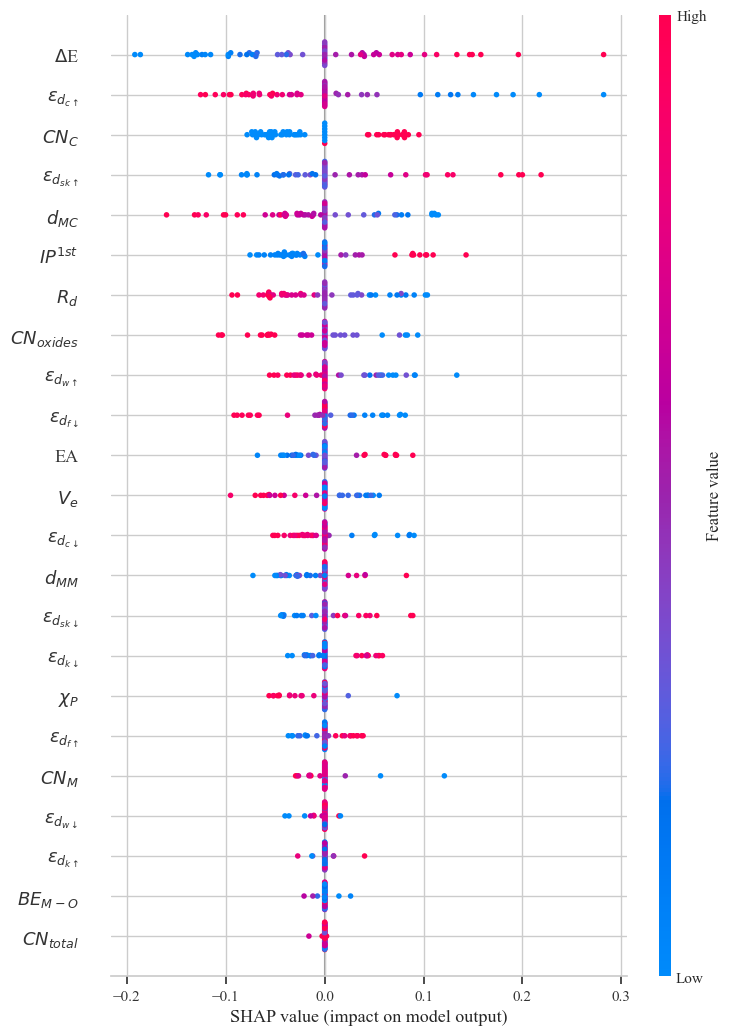

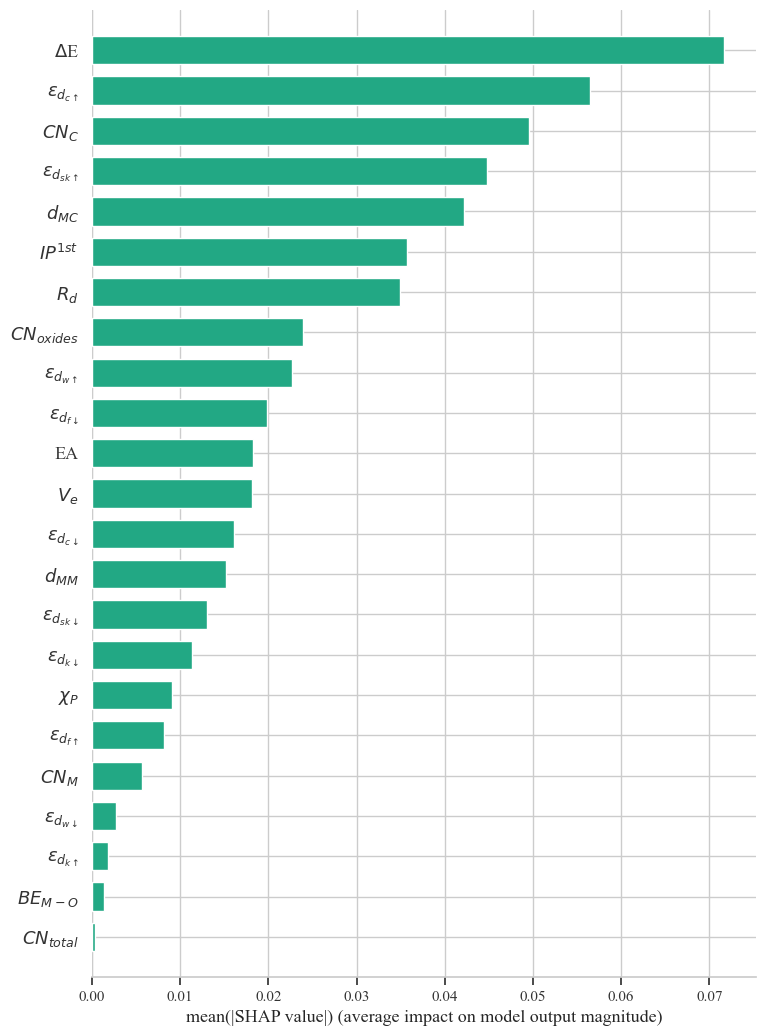

In [14]:
import shap
import matplotlib.cm as cm

# --- Identify the best model ---
best_row = results_df.sort_values("RMSE_Test").iloc[0]
best_name = best_row.Model
best_params = best_row.Best_Params

print(f"\n🏆 Best model: {best_name} with params {best_params}")

# --- Refit best model on ALL data ---
best_model = base_models[best_name].set_params(**best_params)
X_scaled = scaler.fit_transform(X)   # rescale full dataset
best_model.fit(X_scaled, y)

# --- SHAP analysis ---
explainer = None
if best_name in ["RFR", "ETR", "GBR", "XGBR"]:
    # Tree-based models
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_scaled)
else:
    # Kernel / linear models (slower)
    explainer = shap.KernelExplainer(best_model.predict, X_scaled[:50])  
    shap_values = explainer.shap_values(X_scaled, nsamples=100)

# --- SHAP summary plot (beeswarm) ---
shap.summary_plot(shap_values, X, feature_names=X.columns, max_display=23)
# --- SHAP feature importance (bar plot) ---
shap.summary_plot(shap_values, X, feature_names=X.columns, plot_type="bar", max_display=23, color=cm.viridis(0.6))

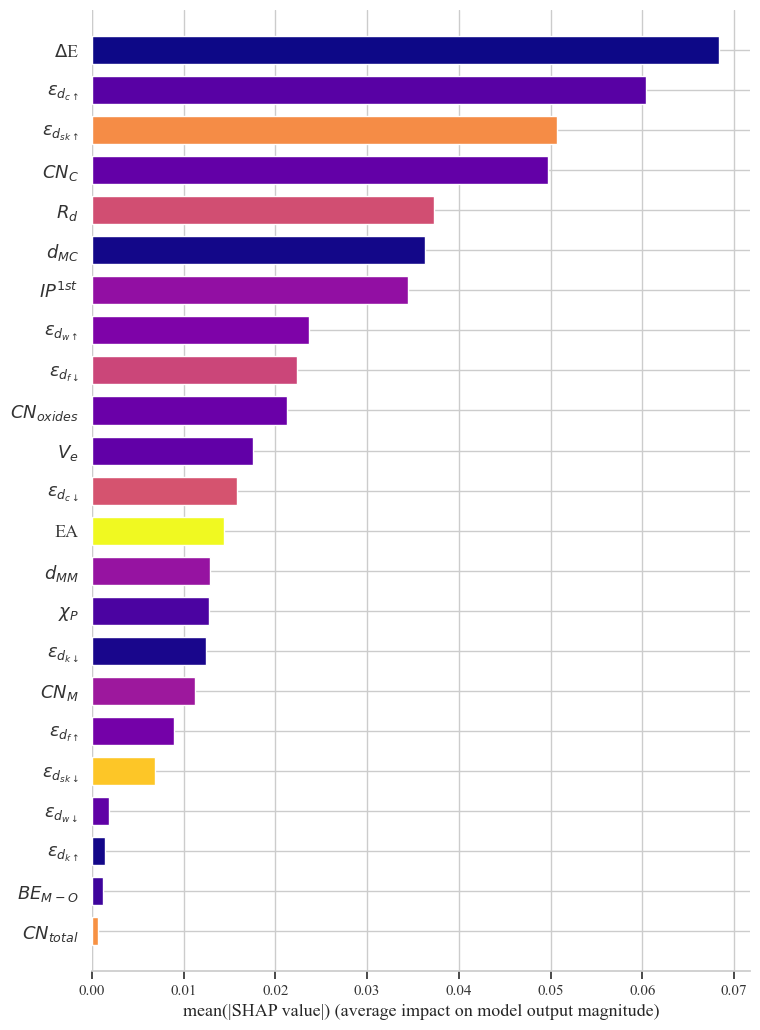

In [11]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# --- SHAP feature importance bar plot ---
shap.summary_plot(shap_values, X, feature_names=X.columns,
                  plot_type="bar", max_display=23, show=False)

# Get bar containers
bars = plt.gca().patches

# Compute mean absolute SHAP values for each feature
values = np.abs(shap_values).mean(0)
values = values[:23]  # match max_display

# Normalize values for colormap
norm = plt.Normalize(values.min(), values.max())
cmap = cm.plasma  # try cm.plasma, cm.inferno, cm.coolwarm, etc.

# Apply gradient coloring across bars
for val, bar in zip(values, bars):
    bar.set_facecolor(cmap(norm(val)))

plt.show()

🌲 ETR Model: XGBR with params {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}
Computing SHAP values for XGBR model...
SHAP values shape: (61, 23)
Number of features: 23

Top 15 most important features in XGBR model:
                        feature  importance
  $\varepsilon_{d_{f\uparrow}}$    0.103615
                      $\Delta$E    0.097092
  $\varepsilon_{d_{c\uparrow}}$    0.068501
                       $d_{MC}$    0.056815
$\varepsilon_{d_{f\downarrow}}$    0.052212
                          $R_d$    0.033538
 $\varepsilon_{d_{sk\uparrow}}$    0.027234
  $\varepsilon_{d_{k\uparrow}}$    0.016004
$\varepsilon_{d_{c\downarrow}}$    0.015597
                         $CN_C$    0.012778
                       $d_{MM}$    0.012589
$\varepsilon_{d_{w\downarrow}}$    0.010052
                         $CN_M$    0.009802
  $\varepsilon_{d_{w\uparrow}}$    0.009252
                  $CN_{oxides}$    0.007235


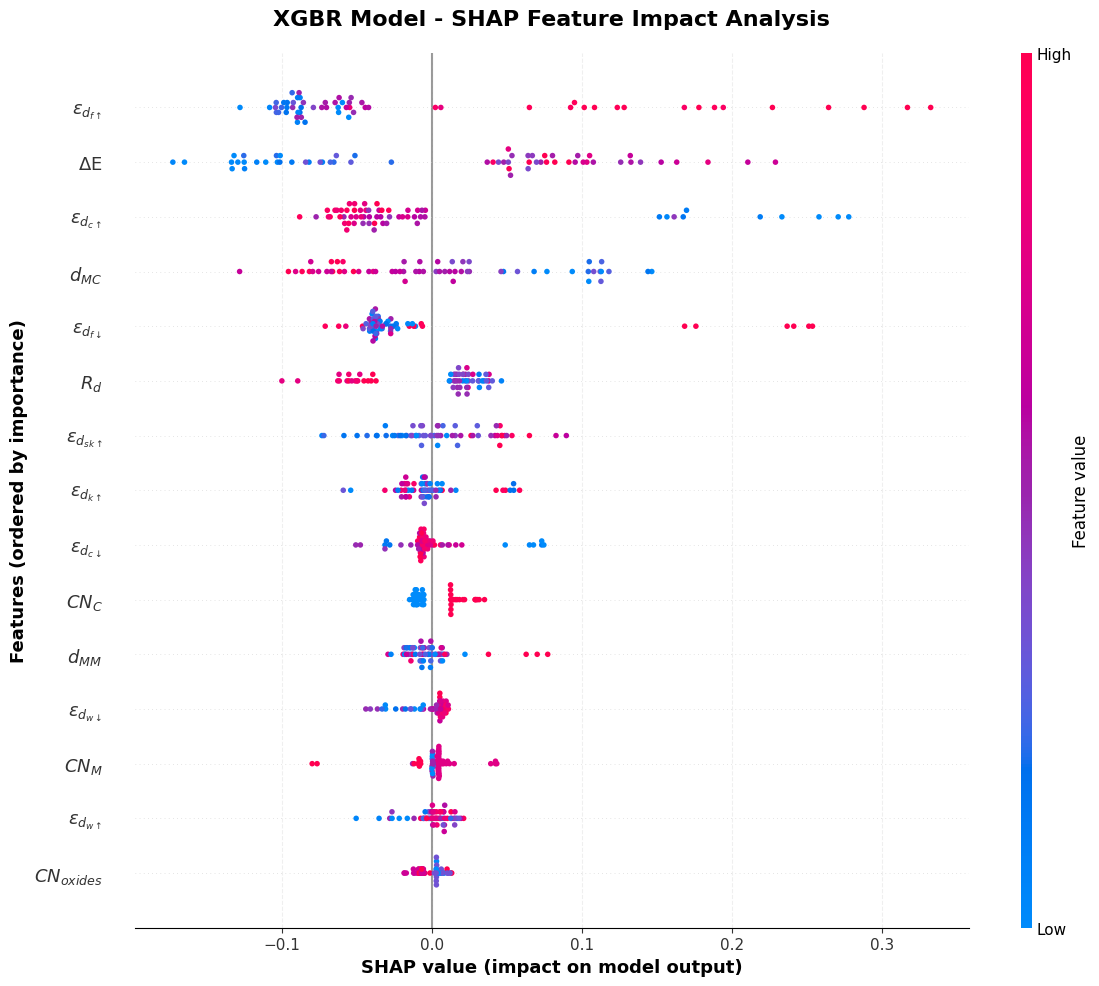

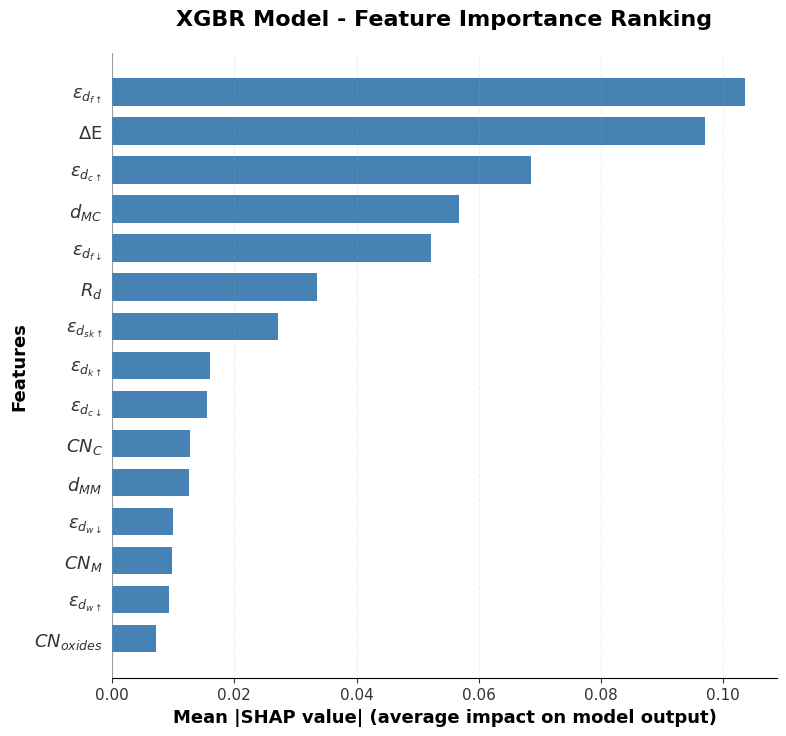


Creating enhanced XGBR SHAP analysis...


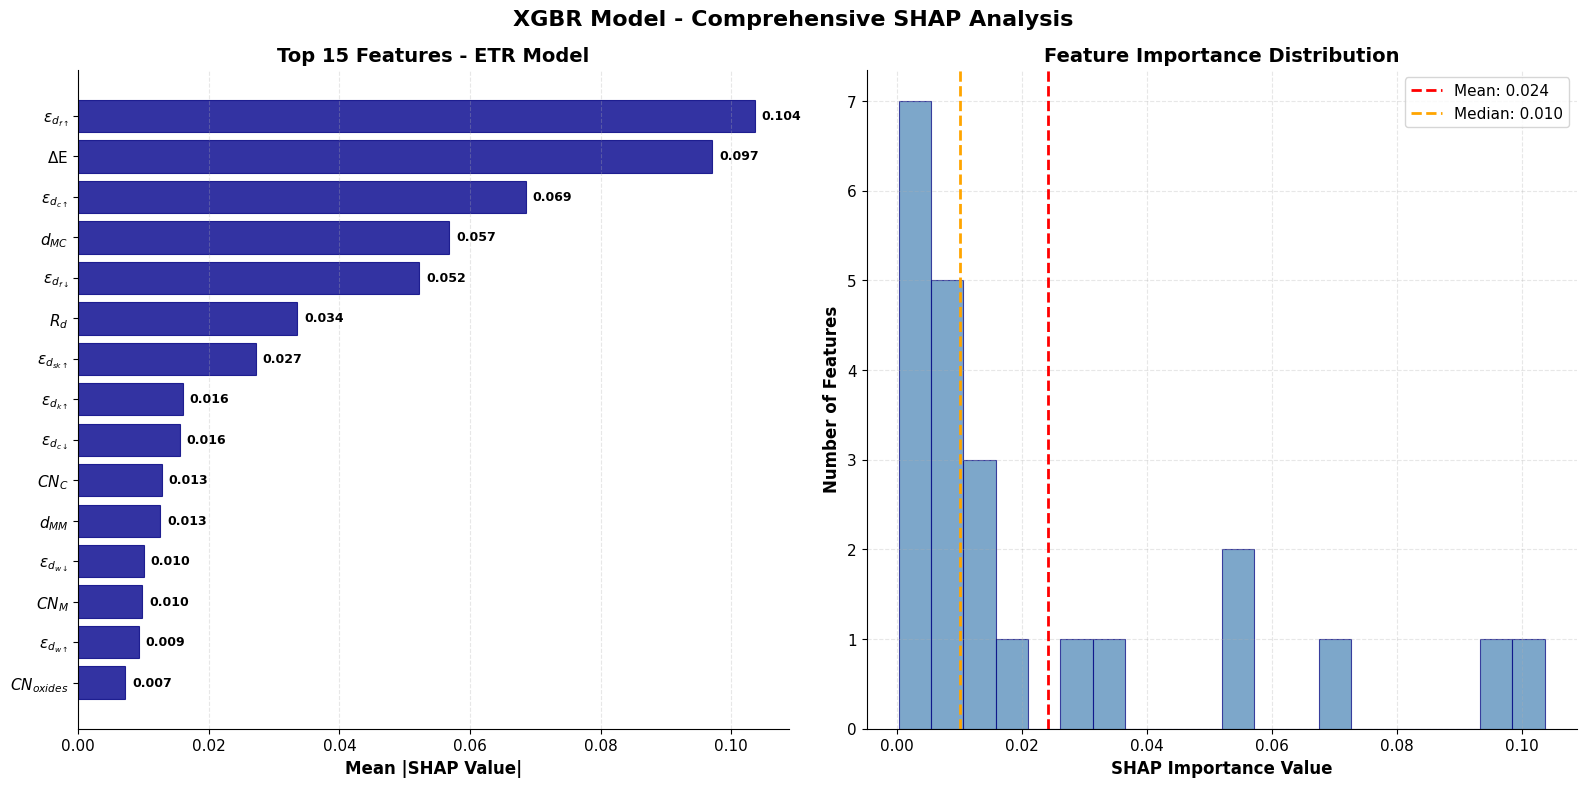


🔍 XGBR MODEL - DETAILED SHAP ANALYSIS

🏆 TOP 5 MOST IMPORTANT FEATURES:
1. $\varepsilon_{d_{f\uparrow}}$: 0.1036
2. $\Delta$E: 0.0971
3. $\varepsilon_{d_{c\uparrow}}$: 0.0685
4. $d_{MC}$: 0.0568
5. $\varepsilon_{d_{f\downarrow}}$: 0.0522

📊 FEATURE IMPORTANCE STATISTICS:
Total features analyzed: 23
Mean importance: 0.0241
Standard deviation: 0.0299
Most important feature: $\varepsilon_{d_{f\uparrow}}$ (0.1036)
Least important feature: $V_e$ (0.0003)

💡 FEATURE SELECTION INSIGHTS:
Top 7 features explain 80% of model importance
Top 14 features explain 95% of model importance
Consider focusing on top 7 features for model simplification

🌲 ETR MODEL CHARACTERISTICS:
Model type: Extra Trees Regressor (ensemble of randomized trees)
SHAP explainer: TreeExplainer (fast and exact for tree models)
Feature interactions: Captured through tree splits
Interpretability: High (tree-based model with clear feature importance)

✅ Analysis complete! High-quality plots saved as:
   - etr_shap_summary_impr

In [15]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Get ETR model specifically ---
# Find ETR model from your results
etr_row = results_df[results_df['Model'] == 'XGBR'].sort_values("RMSE_Test").iloc[0]
etr_name = etr_row.Model
etr_params = etr_row.Best_Params

print(f"🌲 ETR Model: {etr_name} with params {etr_params}")

# --- Refit ETR model on ALL data ---
etr_model = base_models['XGBR'].set_params(**etr_params)
X_scaled = scaler.fit_transform(X)   # rescale full dataset
etr_model.fit(X_scaled, y)

# --- SHAP analysis for ETR ---
print("Computing SHAP values for XGBR model...")
explainer = shap.TreeExplainer(etr_model)
shap_values = explainer.shap_values(X_scaled)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Number of features: {X.shape[1]}")

# --- Feature importance analysis ---
feature_importance = np.abs(shap_values).mean(0)
feature_names = X.columns.tolist()

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 15 most important features in XGBR model:")
print(importance_df.head(15).to_string(index=False))

# --- HIGH-QUALITY ETR SHAP PLOTS ---

# Set up the plotting style
plt.style.use('default')  # Clean style
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# 1. IMPROVED SUMMARY PLOT (Beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values, 
    X, 
    feature_names=X.columns, 
    max_display=15,  # Show top 15 features
    show=False,
    plot_size=None  # We control size with figsize
)

# Customize the summary plot
plt.title('XGBR Model - SHAP Feature Impact Analysis', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=13, fontweight='bold')
plt.ylabel('Features (ordered by importance)', fontsize=13, fontweight='bold')

# Add subtle grid
plt.grid(True, alpha=0.2, axis='x', linestyle='--')
plt.tight_layout()

# Save high-quality version
plt.savefig('etr_shap_summary_improved.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.show()

# 2. FEATURE IMPORTANCE BAR PLOT
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X, 
    feature_names=X.columns, 
    plot_type="bar", 
    max_display=15,
    show=False,
    color='steelblue'  # Single color for bar plot
)

plt.title('XGBR Model - Feature Importance Ranking', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP value| (average impact on model output)', 
           fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')

# Style improvements
plt.grid(True, alpha=0.2, axis='x', linestyle='--')
plt.tight_layout()

# Save high-quality version
plt.savefig('xgbr_feature_importance_improved.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

# 3. CUSTOM ENHANCED PLOT WITH STATISTICS
def create_enhanced_xgbr_plot(shap_values, X, max_features=12):
    """Create an enhanced SHAP plot with additional statistics"""
    
    # Calculate statistics
    feature_importance = np.abs(shap_values).mean(0)
    feature_names = X.columns.tolist()
    
    # Get top features
    top_indices = np.argsort(feature_importance)[-max_features:]
    top_importance = feature_importance[top_indices]
    top_names = [feature_names[i] for i in top_indices]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left plot: Feature importance bars
    y_pos = np.arange(len(top_names))
    bars = ax1.barh(y_pos, top_importance, alpha=0.8, 
                   color='darkblue', edgecolor='navy', linewidth=0.8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_names, fontsize=11)
    ax1.set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
    ax1.set_title(f'Top {max_features} Features - ETR Model', 
                 fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_importance)):
        ax1.text(bar.get_width() + max(top_importance)*0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{value:.3f}', 
                va='center', fontsize=9, fontweight='bold')
    
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Right plot: Importance distribution
    ax2.hist(feature_importance, bins=20, alpha=0.7, color='steelblue', 
            edgecolor='navy', linewidth=0.8)
    ax2.axvline(np.mean(feature_importance), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {np.mean(feature_importance):.3f}')
    ax2.axvline(np.median(feature_importance), color='orange', linestyle='--', 
               linewidth=2, label=f'Median: {np.median(feature_importance):.3f}')
    
    ax2.set_xlabel('SHAP Importance Value', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
    ax2.set_title('Feature Importance Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.suptitle('XGBR Model - Comprehensive SHAP Analysis', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    return fig

# Create enhanced plot
print("\nCreating enhanced XGBR SHAP analysis...")
fig_enhanced = create_enhanced_xgbr_plot(shap_values, X, max_features=15)
plt.savefig('etr_enhanced_shap_analysis.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

# --- DETAILED ANALYSIS OUTPUT ---
print("\n" + "="*60)
print("🔍 XGBR MODEL - DETAILED SHAP ANALYSIS")
print("="*60)

# Top features analysis
top_5_features = importance_df.head(5)
print(f"\n🏆 TOP 5 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f}")

# Feature importance statistics
print(f"\n📊 FEATURE IMPORTANCE STATISTICS:")
print(f"Total features analyzed: {len(feature_names)}")
print(f"Mean importance: {feature_importance.mean():.4f}")
print(f"Standard deviation: {feature_importance.std():.4f}")
print(f"Most important feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})")
print(f"Least important feature: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")

# Cumulative importance analysis
cumulative_importance = importance_df['importance'].cumsum() / importance_df['importance'].sum()
features_80_percent = len(cumulative_importance[cumulative_importance <= 0.8])
features_95_percent = len(cumulative_importance[cumulative_importance <= 0.95])

print(f"\n💡 FEATURE SELECTION INSIGHTS:")
print(f"Top {features_80_percent} features explain 80% of model importance")
print(f"Top {features_95_percent} features explain 95% of model importance")
print(f"Consider focusing on top {min(15, features_80_percent)} features for model simplification")

# Model interpretation
print(f"\n🌲 ETR MODEL CHARACTERISTICS:")
print(f"Model type: Extra Trees Regressor (ensemble of randomized trees)")
print(f"SHAP explainer: TreeExplainer (fast and exact for tree models)")
print(f"Feature interactions: Captured through tree splits")
print(f"Interpretability: High (tree-based model with clear feature importance)")

print(f"\n✅ Analysis complete! High-quality plots saved as:")
print(f"   - etr_shap_summary_improved.png")
print(f"   - etr_feature_importance_improved.png") 
print(f"   - etr_enhanced_shap_analysis.png")